In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
from ipynb.fs.full.Data_Processing import *
from ipynb.fs.full.evaluation import *
from braindecode.datasets.xy import create_from_X_y
import time
import numpy as np
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
from collections import namedtuple
import pickle
from sklearn.model_selection import KFold

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

In [3]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [4]:
def choose_cnn (cnn, trainset, validset , n_classes , device, cuda , n_epochs):
    # Extract number of chans and time steps from dataset
    n_chans = trainset[0][0].shape[0]
    input_window_samples = trainset[0][0].shape[1]

    if cnn == 'shallow':
        lr = 0.0625 * 0.01
        weight_decay = 0
        model =  ShallowFBCSPNet(n_chans, n_classes, input_window_samples=input_window_samples, final_conv_length="auto")
    else:
        lr = 1 * 0.01
        weight_decay = 0.5 * 0.001
        """
        For 30 samples, filter time_length = 1
        For 60 > samples, filter time length is left empty
        for 15 samples, filter_time length = 1, filter_length_2 = 1, filter_length_3 = 1
        """
        model =  Deep4Net(n_chans, n_classes, input_window_samples=input_window_samples,
                  final_conv_length="auto", pool_time_length=1, filter_time_length = 1,pool_time_stride=1)
    if cuda:
        model = model.cuda(0)

    batch_size = 32

    clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(validset),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,)
    return clf

In [5]:
def average(lst): 
    return sum(lst) / len(lst)

In [6]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [7]:
def is_slice_in_list(s,l):
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [12]:
def kfold_predict (X,y, model_type, n_epochs):
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)

    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}

    total_predictions = []
    total_true = []
    num_classes = 0
    clf = None
    for train_index, test_index in kf.split(X):
        print("Train: ", train_index, "Validation: ", test_index)

        #Train/test split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))

        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        print(set(y_train))
        print(set(y_valid))

        size = len(X_train) + len(X_valid) #get dataset size

        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables 
        y_train, y_valid, le = categorise(y_train, y_valid)

        # Convert training and validation sets into a suitable format
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        trainset = create_from_X_y(X_train, y_train, drop_last_window=False)
        validset = create_from_X_y(X_valid, y_valid, drop_last_window=False)
        sys.stdout = save_stdout

        # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))

        # commence the training process
        time_start = time.time()
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        clf = choose_cnn ('deep', trainset, validset , num_classes , device, cuda, n_epochs).fit(trainset, y=None, epochs=n_epochs)
        sys.stdout = save_stdout
        print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

        # make predictions
        y_pred = le.inverse_transform(clf.predict(X_valid))
        y_true = le.inverse_transform(y_valid)
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type)

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        

    for key in results: # finallly average out the results 
        results[key] = average(results[key])
    print("Accuracy".format(results['Accuracy']))
    return results, np.concatenate(total_predictions), np.concatenate(total_true), num_classes, size , clf

Working on user 1
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.32369065284729 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 88.80192971229553 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 91.56071496009827 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.53205585479736 seconds
Accuracy
Normalized confusion matrix
[[0.37037037 0.06666667 0.27777778 0.28518519]
 [0.25026624 0.31842386 0.32587859 0.10543131]
 [0.41987179 0.31730769 0.16185897 0.10096154]
 [0.45759717 0.24028269 0.09893993 0.20318021]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Finished analysis on User 1_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 93.0180070400238 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.20763540267944 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 91.2489333152771 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 90.09108090400696 seconds
Accuracy
Normalized confusion matrix
[[0.         0.62056738 0.37943262 0.        ]
 [0.34747475 0.31111111 0.34141414 0.        ]
 [0.0962963  0.17566138 0.58941799 0.13862434]
 [0.09355509 0.68191268 0.22453222 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 1_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.47964882850647 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 93.05664920806885 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.10712337493896 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 91.63428592681885 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 89.79289174079895 seconds
Accuracy
Normalized confusion matrix
[[0.         0.         0.75247525 0.24752475 0.        ]
 [0.         0.         0.73493976 0.26506024 0.        ]
 [0.         0.08530319 0.46659815 0.44809866 0.        ]
 [0.         0.21508035 0.57354759 0.21137206 0.        ]
 [0.         0.47826087 0.         0.52173913 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 1_effort
Finished analysis on User 1
Working on user 2
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 163.9427330493927 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 162.1179735660553 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 168.60470008850098 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 170.5176341533661 seconds
Accuracy
Normalized confusion matrix
[[0.29503676 0.30514706 0.39981618]
 [0.57833333 0.0725     0.34916667]
 [0.47531231 0.24628198 0.27840571]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 2_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 161.87877798080444 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 168.84827542304993 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 170.8837010860443 seconds
Accuracy
Normalized confusion matrix
[[0.60758377 0.3659612  0.02645503]
 [0.70715835 0.00650759 0.28633406]
 [0.42289157 0.13855422 0.43855422]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 2_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 162.10130906105042 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 164.46003007888794 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 161.62955617904663 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 168.53653836250305 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.41269841 0.16269841 0.23174603 0.06349206 0.12936508]
 [0.30856068 0.15145814 0.35183443 0.18814675 0.        ]
 [0.45058448 0.12752391 0.09351753 0.17321998 0.15515409]
 [0.13397129 0.24082935 0.         0.62519936 0.        ]
 [0.20711297 0.37238494 0.         0.42050209 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 2_effort
Finished analysis on User 2
Working on user 3
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.13678550720215 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.67931151390076 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 157.77802681922913 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.56331586837769 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.         0.41666667 0.2962963  0.         0.28703704]
 [0.43167028 0.06073753 0.14533623 0.         0.36225597]
 [0.08898305 0.11228814 0.26624294 0.32132768 0.21115819]
 [0.         0.07482993 0.2532124  0.31746032 0.35449735]
 [0.         0.         0.21473029 0.28630705 0.49896266]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 3_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.3890573978424 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 151.68330430984497 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.40855526924133 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 162.6179974079132 seconds
Accuracy
Normalized confusion matrix
[[0.         0.16605166 0.64206642 0.         0.19188192]
 [0.         0.04946996 0.         0.51236749 0.43816254]
 [0.         0.28767123 0.09215442 0.36239103 0.25778331]
 [0.         0.17123795 0.06375093 0.50185322 0.26315789]
 [0.         0.21833648 0.13705104 0.25425331 0.39035917]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 3_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.76081347465515 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 151.3808696269989 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 158.03630661964417 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.59342241287231 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 162.74571776390076 seconds
Accuracy
Normalized confusion matrix
[[0.02795031 0.41925466 0.14906832 0.40372671 0.        ]
 [0.13280632 0.44505929 0.10988142 0.31225296 0.        ]
 [0.07232913 0.30258792 0.09024552 0.53483743 0.        ]
 [0.15054602 0.24414977 0.14820593 0.45709828 0.        ]
 [0.         0.08352668 0.41299304 0.50348028 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 3_effort
Finished analysis on User 3
Working on user 6
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 175.4854257106781 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 187.40094542503357 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.38328623771667 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 179.61825108528137 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.52082562446594 seconds
Accuracy
Normalized confusion matrix
[[0.23076923 0.30445344 0.46477733]
 [0.19298867 0.24822946 0.55878187]
 [0.05353846 0.37969231 0.56676923]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished analysis on User 6_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 175.78263354301453 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 187.29328870773315 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.50344467163086 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 179.10427594184875 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.42341804504395 seconds
Accuracy
Normalized confusion matrix
[[0.44600432 0.19618431 0.35781138]
 [0.29178312 0.24762437 0.46059251]
 [0.11459266 0.32229185 0.56311549]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 6_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 174.72908639907837 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 187.95587635040283 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.32781958580017 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 179.02093887329102 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.94124364852905 seconds
Accuracy
Normalized confusion matrix
[[0.32081911 0.221843   0.45733788 0.         0.        ]
 [0.02263494 0.09866512 0.49680789 0.33952409 0.04236796]
 [0.         0.22399151 0.45647558 0.28768577 0.03184713]
 [0.         0.20467422 0.38456091 0.29603399 0.11473088]
 [0.         0.32526882 0.33602151 0.17473118 0.16397849]]


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 6_effort
Finished analysis on User 6
Working on user 7
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 186.5377881526947 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.5888795852661 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 186.6088924407959 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.83478164672852 seconds
Accuracy
Normalized confusion matrix
[[0.608577   0.391423   0.        ]
 [0.96893788 0.03106212 0.        ]
 [0.96470588 0.03529412 0.        ]]


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 7_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4}
{3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 187.2704997062683 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4}
{3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.31643390655518 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.4920573234558 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.12551498413086 seconds
Accuracy
Normalized confusion matrix
[[0.         0.28571429 0.71428571]
 [0.         0.22762545 0.77237455]
 [0.         0.33306773 0.66693227]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 7_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.8447926044464 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 186.20914268493652 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.1271677017212 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 185.8470437526703 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 184.71811270713806 seconds
Accuracy
Normalized confusion matrix

/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



[[0.41645244 0.         0.58354756 0.        ]
 [0.09937238 0.55230126 0.34832636 0.        ]
 [0.15637652 0.71002024 0.13360324 0.        ]
 [0.         0.93613139 0.06386861 0.        ]]


ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 7_effort
Finished analysis on User 7
Working on user 8
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 225.3298978805542 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 239.7434184551239 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 245.82776641845703 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.67924528 0.         0.         0.32075472]
 [0.         0.20743405 0.117506   0.00119904 0.67386091]
 [0.         0.45621181 0.         0.21588595 0.32790224]
 [0.         0.40963015 0.09351012 0.17725052 0.31960921]
 [0.         0.23505709 0.04969778 0.         0.71524513]]


ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 8_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 222.9862620830536 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 232.30332684516907 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 238.31408071517944 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.13577023 0.         0.         0.86422977]
 [0.         0.52095808 0.         0.0988024  0.38023952]
 [0.         0.1056701  0.         0.125      0.7693299 ]
 [0.         0.14272644 0.04117109 0.21957914 0.59652333]
 [0.         0.25886713 0.11964002 0.01217575 0.6093171 ]]


ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 8_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 223.26681280136108 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 234.1288411617279 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 241.11097025871277 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 238.40954446792603 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 246.24937343597412 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Normalized confusion matrix
[[0.01865009 0.63854352 0.12788632 0.         0.21492007]
 [0.02210315 0.25251172 0.15874079 0.06630944 0.5003349 ]
 [0.05022831 0.4414003  0.20395738 0.01217656 0.29223744]
 [0.02920561 0.41063084 0.03504673 0.22196262 0.30315421]
 [0.         0.44788614 0.05692758 0.22143156 0.27375471]]


ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 8_effort
Finished analysis on User 8
Working on user 9
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 273.2045214176178 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 270.8327944278717 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 263.8604509830475 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 260.9438762664795 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 274.5753538608551 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.         0.31117825 0.         0.68882175]
 [0.         0.15814394 0.53693182 0.14204545 0.16287879]
 [0.         0.14906264 0.53452218 0.11065386 0.20576132]
 [0.         0.05647969 0.30599613 0.06305609 0.57446809]
 [0.         0.03225806 0.2403453  0.13357565 0.59382099]]
Finished analysis on User 9_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 272.6606869697571 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 270.21474409103394 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 261.45515990257263 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 262.0579454898834 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 274.239355802536 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Normalized confusion matrix
[[0.13578275 0.         0.50798722 0.         0.35623003]
 [0.         0.         0.33365019 0.22623574 0.44011407]
 [0.11494253 0.         0.19667944 0.24010217 0.44827586]
 [0.04022526 0.         0.15325825 0.13314562 0.67337088]
 [0.07718631 0.08935361 0.19581749 0.28403042 0.35361217]]
Finished analysis on User 9_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 272.0334770679474 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 269.72033309936523 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 261.34854888916016 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 274.47270345687866 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Normalized confusion matrix
[[0.58326908 0.07093292 0.11680802 0.11410948 0.11488049]
 [0.66267806 0.25242165 0.         0.03874644 0.04615385]
 [0.22923588 0.50941307 0.10963455 0.1517165  0.        ]
 [0.5640423  0.10223267 0.27144536 0.         0.06227967]
 [0.43630573 0.47452229 0.08917197 0.         0.        ]]
Finished analysis on User 9_effort
Finished analysis on User 9
Working on user 10
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 4, 5}
{1, 2, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 37.64956021308899 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 4, 5}
{4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 39.11473894119263 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 4, 5}
{1, 2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 39.05105900764465 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 4, 5}
{2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 38.622071504592896 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.         0.47402597 0.52597403 0.        ]
 [0.3875     0.         0.6125     0.        ]
 [0.17647059 0.         0.82352941 0.        ]
 [0.57664234 0.42335766 0.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 10_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 4, 5}
{1, 2, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 37.491180181503296 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 4, 5}
{2, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 38.74836230278015 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 4, 5}
{4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 38.360591650009155 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 4, 5}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 37.96559405326843 seconds
Accuracy
Normalized confusion matrix
[[0.         0.56462585 0.19387755 0.2414966 ]
 [0.60352423 0.03964758 0.35682819 0.        ]
 [0.30357143 0.46428571 0.23214286 0.        ]
 [1.         0.         0.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 10_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 4, 5}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 39.10985589027405 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 4, 5}
{2, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 38.21815633773804 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 4, 5}
{1, 2, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 38.209572076797485 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 4, 5}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 38.42166447639465 seconds
Accuracy
Normalized confusion matrix
[[0.         0.47692308 0.15       0.37307692]
 [0.         0.36781609 0.         0.63218391]
 [0.33944954 0.66055046 0.         0.        ]
 [0.69633508 0.30366492 0.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 10_effort
Finished analysis on User 10
Working on user 11
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 86.95721006393433 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 90.6763014793396 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 90.99303030967712 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 85.92477011680603 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.         0.         1.         0.         0.        ]
 [0.         0.         0.17857143 0.73979592 0.08163265]
 [0.48331108 0.00267023 0.         0.39919893 0.11481976]
 [0.31707317 0.05090138 0.01060445 0.621421   0.        ]
 [0.30909091 0.         0.69090909 0.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 11_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 87.10791397094727 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 90.93231129646301 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 86.01554298400879 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [0.         0.005      0.855      0.         0.14      ]
 [0.26341463 0.22439024 0.30731707 0.         0.20487805]
 [0.5175644  0.28571429 0.19672131 0.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 11_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 87.3047285079956 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 86.07411098480225 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 85.93996453285217 seconds
Accuracy
Normalized confusion matrix
[[0.07954545 0.56818182 0.22222222 0.         0.13005051]
 [0.22920892 0.67139959 0.09939148 0.         0.        ]
 [0.27882038 0.30563003 0.10723861 0.         0.30831099]
 [0.75102041 0.24897959 0.         0.         0.        ]
 [       nan        nan        nan        nan        nan]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 11_effort
Finished analysis on User 11
Working on user 12
Train:  [0 1 3 4 5 6 7] Validation:  [2 8]
{2, 3}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 12.35008454322815 seconds
Train:  [0 1 2 3 4 5 8] Validation:  [6 7]
{2, 3}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 11.842621088027954 seconds
Train:  [2 3 4 5 6 7 8] Validation:  [0 1]
{2, 3}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 10.314384460449219 seconds
Train:  [0 1 2 5 6 7 8] Validation:  [3 4]
{2, 3}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 13.027130365371704 seconds
Train:  [0 1 2 3 4 6 7 8] Validation:  [5]
{2, 3}
{2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 13.098665475845337 seconds
Accuracy
Normalized confusion matrix
[[0.53846154 0.46153846]
 [0.53333333 0.46666667]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 12_attention
Train:  [0 1 3 4 5 6 7] Validation:  [2 8]
Train:  [0 1 2 3 4 5 8] Validation:  [6 7]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 11.866031169891357 seconds
Train:  [2 3 4 5 6 7 8] Validation:  [0 1]
Train:  [0 1 2 5 6 7 8] Validation:  [3 4]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 13.031693935394287 seconds
Train:  [0 1 2 3 4 6 7 8] Validation:  [5]
{1, 2, 3, 4}
{3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 13.079755783081055 seconds
Accuracy
Normalized confusion matrix
[[       nan        nan        nan]
 [0.         0.65934066 0.34065934]
 [0.22916667 0.22916667 0.54166667]]


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 12_interest
Train:  [0 1 3 4 5 6 7] Validation:  [2 8]
{2, 3, 4, 5}
{3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 12.40096926689148 seconds
Train:  [0 1 2 3 4 5 8] Validation:  [6 7]
{2, 3, 4, 5}
{4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 11.78013300895691 seconds
Train:  [2 3 4 5 6 7 8] Validation:  [0 1]
{2, 3, 4, 5}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 10.245450258255005 seconds
Train:  [0 1 2 5 6 7 8] Validation:  [3 4]
Train:  [0 1 2 3 4 6 7 8] Validation:  [5]
{2, 3, 4, 5}
{2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 13.021107196807861 seconds
Accuracy
Normalized confusion matrix
[[0.     1.     0.     0.    ]
 [0.256  0.152  0.592  0.    ]
 [0.     0.9125 0.     0.0875]
 [   nan    nan    nan    nan]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 12_effort
Finished analysis on User 12
Working on user 17
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 115.12487006187439 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.83819365501404 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 110.66614699363708 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 112.97074747085571 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 118.03357362747192 seconds
Accuracy
Normalized confusion matrix
[[0.49680715 0.35696041 0.14623244]
 [0.19745958 0.71882217 0.08371824]
 [0.29019608 0.70980392 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 17_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 114.9099977016449 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.08641147613525 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 110.76721000671387 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 112.7396719455719 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.4487133026123 seconds
Accuracy
Normalized confusion matrix
[[0.60629921 0.34827377 0.04542701]
 [0.22007255 0.61729141 0.16263603]
 [0.12096774 0.55645161 0.32258065]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 17_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 114.92157292366028 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 112.7809190750122 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 110.70249795913696 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.04852962493896 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.67335510253906 seconds
Accuracy
Normalized confusion matrix
[[0.17944398 0.82055602 0.        ]
 [0.21521425 0.69041887 0.09436688]
 [0.25605536 0.44982699 0.29411765]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may c

Finished analysis on User 17_effort
Finished analysis on User 17
Working on user 18
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 192.84763145446777 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 191.57684779167175 seconds
Accuracy
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.0681587  0.16581892 0.2370295  0.         0.52899288]
 [0.         0.1943128  0.08056872 0.         0.72511848]
 [0.33690987 0.30472103 0.14592275 0.         0.21244635]
 [0.60576923 0.16346154 0.         0.23076923 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot

Finished analysis on User 18_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 181.570330619812 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 192.98039484024048 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 191.56855463981628 seconds
Accuracy
Normalized confusion matrix
[[0.28010139 0.16032953 0.25792142 0.30164766]
 [0.29663609 0.30275229 0.24159021 0.15902141]
 [0.58152686 0.         0.23091423 0.18755891]
 [0.77534791 0.         0.08747515 0.13717694]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 18_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 4}
{2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 182.00698566436768 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 4}
{1, 2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 192.94156289100647 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 4}
{1, 2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 189.95474457740784 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 4}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 186.44633984565735 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 4}
{1, 2, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 191.03695797920227 seconds
Accuracy
Normalized confusion matrix
[[0.12212738 0.62705187 0.25082075]
 [0.16323572 0.71469991 0.12206437]
 [0.31818182 0.62305987 0.05875831]]


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 18_effort
Finished analysis on User 18
Working on user 19
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 51.186586141586304 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 51.1013240814209 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 53.05066728591919 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 52.794585943222046 seconds
Accuracy
Normalized confusion matrix
[[0.84573748 0.         0.15426252]
 [0.57077626 0.         0.42922374]
 [0.91402715 0.         0.08597285]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 19_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 51.12778329849243 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 53.21925616264343 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.70889488 0.29110512 0.        ]
 [0.24102564 0.75897436 0.        ]
 [0.         1.         0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 19_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 49.33202815055847 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 51.24658727645874 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 51.409528970718384 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 53.342246770858765 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 52.98878240585327 seconds
Accuracy
Normalized confusion matrix
[[0.51258812 0.24874119 0.23867069]
 [0.45051195 0.07167235 0.4778157 ]
 [0.77955272 0.07667732 0.14376997]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 19_effort
Finished analysis on User 19
Working on user 20
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 155.5650999546051 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 154.77708745002747 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.49989819526672 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.14982578 0.         0.07665505 0.         0.77351916]
 [0.14975845 0.         0.14492754 0.         0.70531401]
 [0.14199396 0.12386707 0.         0.37361531 0.36052367]
 [0.10033167 0.09369818 0.0986733  0.23963516 0.46766169]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 20_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 140.3068528175354 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 156.4928503036499 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.         0.         0.27669903 0.         0.72330097]
 [0.         0.20895522 0.17910448 0.29353234 0.31840796]
 [0.         0.         0.         0.81737194 0.18262806]
 [0.         0.12473573 0.18816068 0.19027484 0.49682875]
 [0.         0.27459618 0.         0.1277533  0.59765051]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 20_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 141.3500039577484 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 155.44678211212158 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 153.28370428085327 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.57229375839233 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.12059369 0.         0.         0.51205937 0.36734694]
 [0.38229755 0.         0.         0.39359699 0.22410546]
 [0.062249   0.         0.         0.64056225 0.29718876]
 [0.25254105 0.13604378 0.         0.38467553 0.22673964]
 [0.59725686 0.0436409  0.         0.23441397 0.12468828]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 20_effort
Finished analysis on User 20
Working on user 22
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 145.7234649658203 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.04118752479553 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 146.91953802108765 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 145.74057507514954 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 147.9636423587799 seconds
Accuracy
Normalized confusion matrix
[[0.         0.35102041 0.64897959 0.        ]
 [0.04050356 0.49315818 0.43623426 0.030104  ]
 [0.05687438 0.53016815 0.30069238 0.11226508]
 [0.06868687 0.3010101  0.63030303 0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 22_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 145.44931721687317 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.59119248390198 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.63324093818665 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 145.55879640579224 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
Accuracy
Normalized confusion matrix
[[0.         0.29739777 0.70260223 0.        ]
 [0.         0.54393771 0.45606229 0.        ]
 [0.         0.32963648 0.63093038 0.03943315]
 [0.         0.2886049  0.7113951  0.        ]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 22_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 150.4198887348175 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 147.29755282402039 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 146.12708258628845 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 148.10009217262268 seconds
Accuracy
Normalized confusion matrix
[[0.11297071 0.68559474 0.20143455]
 [0.40477816 0.57269625 0.0225256 ]
 [0.70982143 0.29017857 0.        ]]


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 22_effort
Finished analysis on User 22
Working on user 23
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 241.5095853805542 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 252.9397370815277 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 256.4645879268646 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 250.63891768455505 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 259.22831773757935 seconds
Accuracy


ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.         0.23125    0.76875    0.        ]
 [0.         0.28994544 0.         0.50272798 0.20732658]
 [0.05823476 0.18789809 0.00864422 0.44722475 0.29799818]
 [0.10859055 0.0896244  0.30457419 0.25622908 0.24098178]
 [0.1031746  0.14153439 0.33664021 0.37962963 0.03902116]]
Finished analysis on User 23_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 240.95126128196716 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 254.73115062713623 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 249.77642273902893 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 257.9932029247284 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.3994709  0.6005291 ]
 [0.         0.         0.05968992 0.08837209 0.85193798]
 [0.01592624 0.08549874 0.19195306 0.14165968 0.56496228]
 [0.08571429 0.26305419 0.33349754 0.0270936  0.29064039]]
Finished analysis on User 23_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 242.5205807685852 seconds
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 251.8854444026947 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 254.56085729599 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 258.72711968421936 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         0.21289062 0.5703125  0.21679688]
 [0.07175056 0.48422239 0.34447784 0.09954921]
 [0.25298211 0.32306163 0.41600398 0.00795229]
 [0.38988095 0.19146825 0.39980159 0.01884921]]
Finished analysis on User 23_effort
Finished analysis on User 23
Working on user 24
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.53849387168884 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.7013807296753 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.71236395835876 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 120.43349075317383 seconds
Accuracy
Normalized confusion matrix
[[0.         0.13461538 0.86538462 0.        ]
 [0.16801948 0.60308442 0.13311688 0.09577922]
 [0.08348794 0.38868275 0.43970315 0.08812616]
 [0.         0.00931677 0.50931677 0.48136646]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 24_attention
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.67659640312195 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.73931670188904 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 117.12637948989868 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 120.61053919792175 seconds
Accuracy
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.         0.11557789 0.13316583 0.44221106 0.30904523]
 [0.09902371 0.41980474 0.         0.45746165 0.0237099 ]
 [0.         0.41975309 0.         0.34283001 0.2374169 ]
 [0.         0.1627907  0.05426357 0.50581395 0.27713178]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:34: RuntimeWarning: invalid value encountered in true_divide
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 24_interest
Train:  [ 0  1  4  5  6  8  9 10 11 12 14 15] Validation:  [ 2  3  7 13]
Train:  [ 0  1  2  3  5  7  8  9 11 12 13 14 15] Validation:  [ 4  6 10]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 117.16928887367249 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 13 15] Validation:  [ 0  1 14]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 113.82262659072876 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14] Validation:  [ 8  9 15]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Training completed created! Time elapsed: 117.31413459777832 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 121.0205397605896 seconds
Accuracy
Normalized confusion matrix
[[       nan        nan        nan        nan        nan]
 [0.00692042 0.26643599 0.37716263 0.23269896 0.11678201]
 [0.         0.42020666 0.33983927 0.17451206 0.06544202]
 [0.         0.21917808 0.25114155 0.52968037 0.        ]
 [       nan        nan        nan        nan        nan]]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Finished analysis on User 24_effort
Finished analysis on User 24
Working on user 25
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 272.83710289001465 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 277.6134076118469 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 288.2739233970642 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 276.5256037712097 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.         1.         0.         0.        ]
 [0.         0.38004402 0.61995598 0.        ]
 [0.         0.83045455 0.16954545 0.        ]
 [0.         0.63222749 0.36777251 0.        ]]


ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Finished analysis on User 25_attention
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 272.9682602882385 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4, 5}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 277.91256308555603 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4, 5}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 278.0407109260559 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4, 5}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 288.4080185890198 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 278.1302173137665 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ipynb.fs.full.evaluation:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Normalized confusion matrix
[[0.1856492  0.54214123 0.         0.27220957 0.        ]
 [0.13939094 0.32334736 0.20401089 0.3332508  0.        ]
 [0.         0.48100134 0.29056772 0.22843093 0.        ]
 [0.         0.79600333 0.20399667 0.         0.        ]
 [0.         0.38271605 0.61728395 0.         0.        ]]
Finished analysis on User 25_interest
Train:  [ 0  1  2  4  5  8  9 10 11 12 13 14] Validation:  [3 6 7]
{1, 2, 3, 4}
{2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 272.9249355792999 seconds
Train:  [ 0  1  3  5  6  7  8  9 11 12 13 14] Validation:  [ 2  4 10]
{1, 2, 3, 4}
{1, 2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible.

Training completed created! Time elapsed: 277.39716506004333 seconds
Train:  [ 2  3  4  5  6  7  8  9 10 11 12 14] Validation:  [ 0  1 13]
{1, 2, 3, 4}
{1, 2}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 276.93754291534424 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13] Validation:  [ 8  9 14]
{1, 2, 3, 4}
{2, 3, 4}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 286.7282211780548 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14] Validation:  [ 5 11 12]
{1, 2, 3, 4}
{1, 2, 3}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 276.82057881355286 seconds
Accuracy


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
ipynb.fs.full.evaluation:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

Normalized confusion matrix
[[0.         0.51162791 0.         0.48837209]
 [0.06863929 0.69041868 0.00563607 0.23530596]
 [0.25915801 0.3570257  0.22799344 0.15582285]
 [0.77533784 0.22466216 0.         0.        ]]
Finished analysis on User 25_effort
Finished analysis on User 25
All analyses are complete! Time elapsed: 38550.57069039345


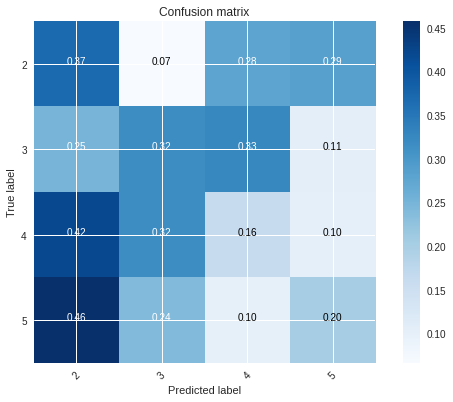

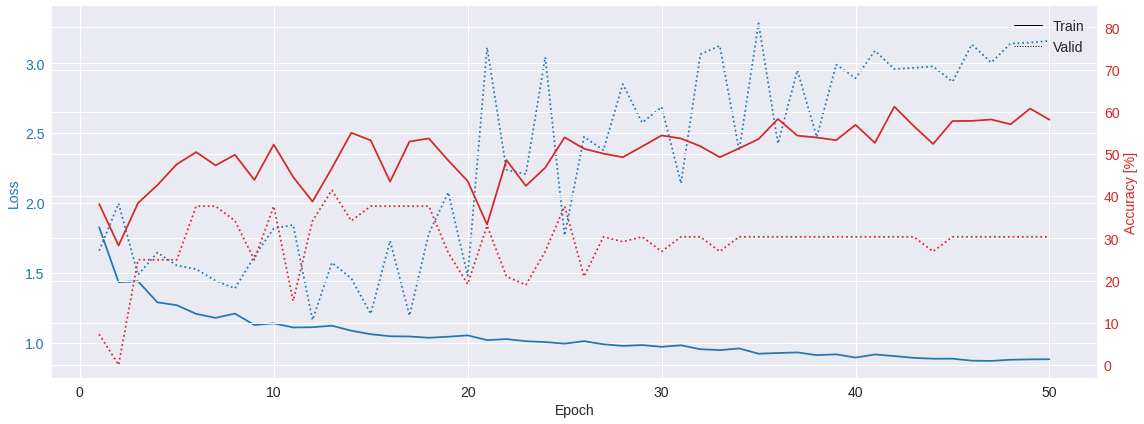

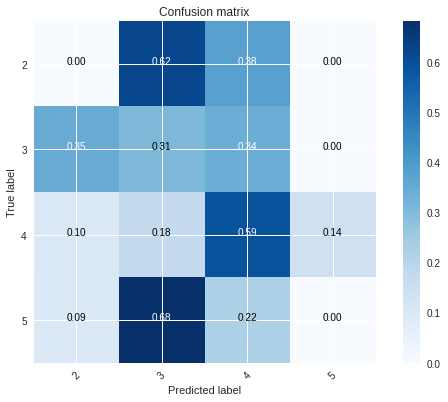

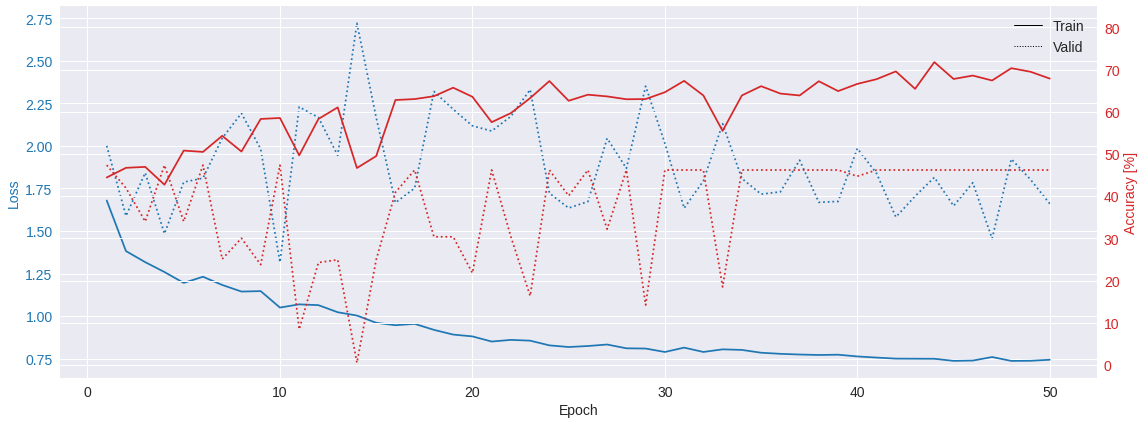

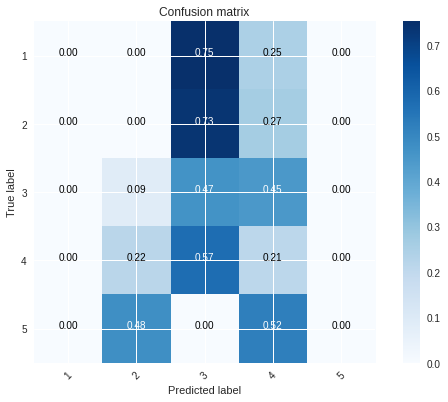

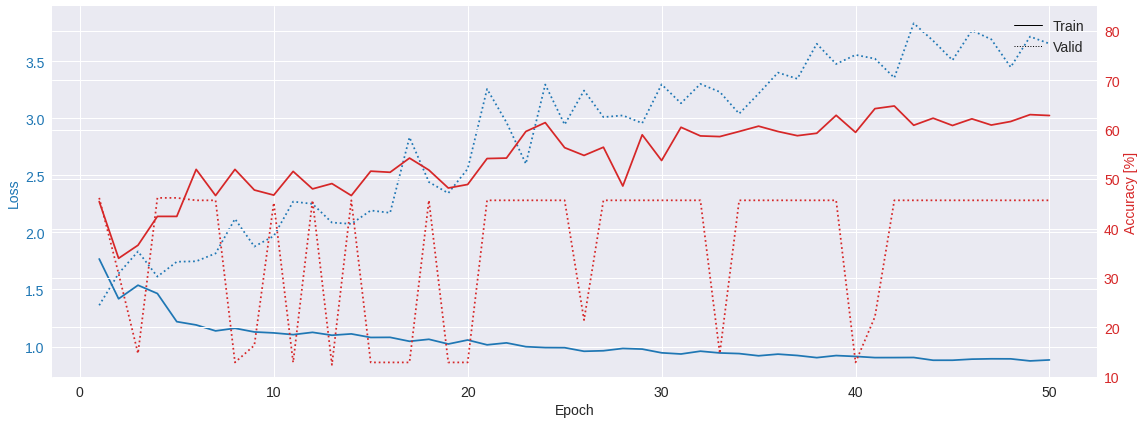

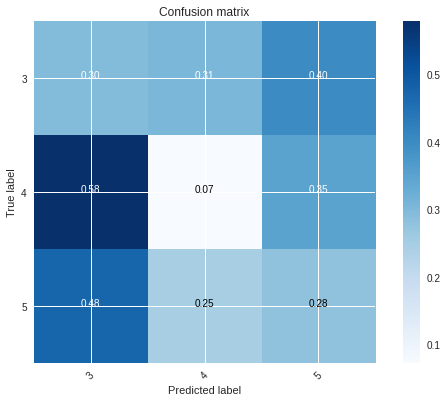

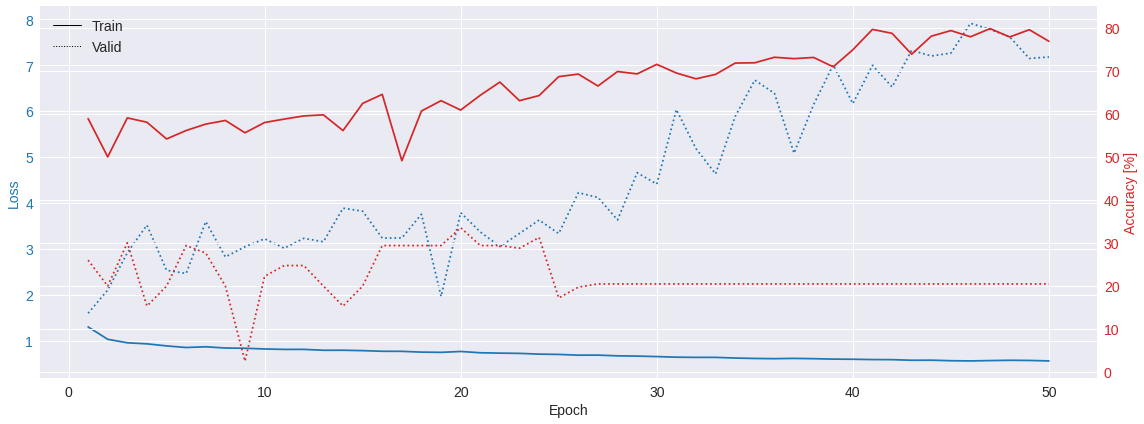

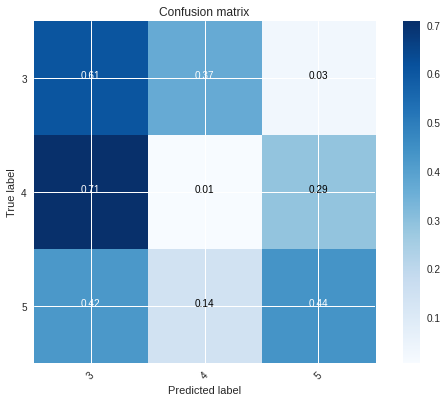

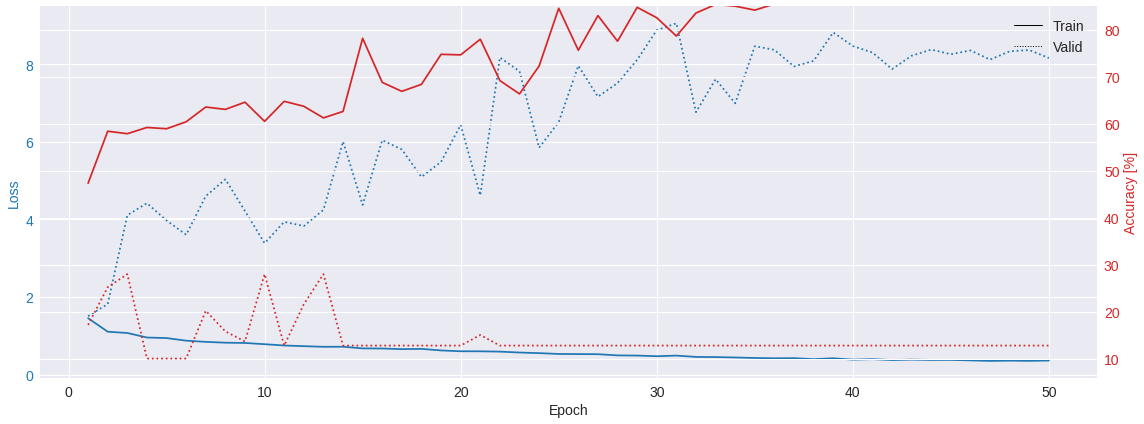

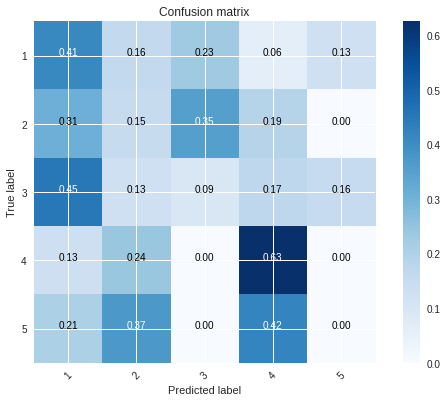

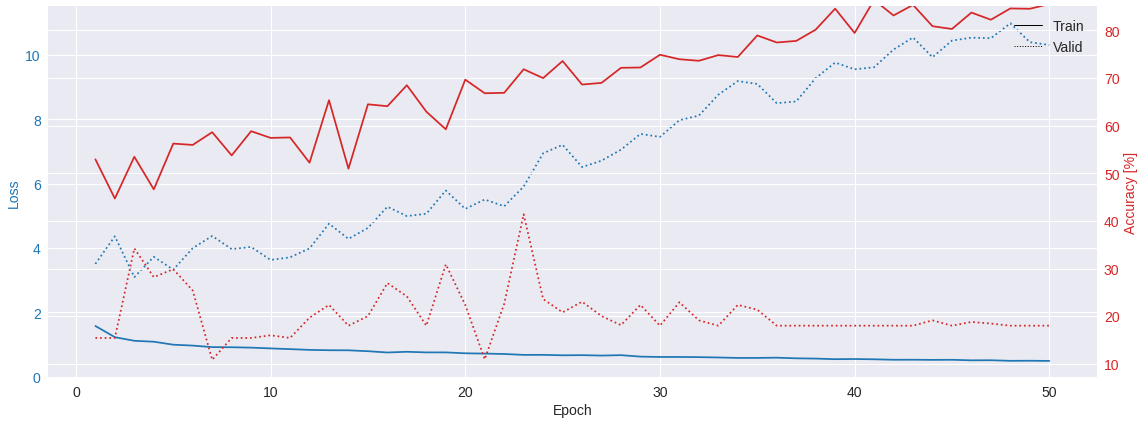

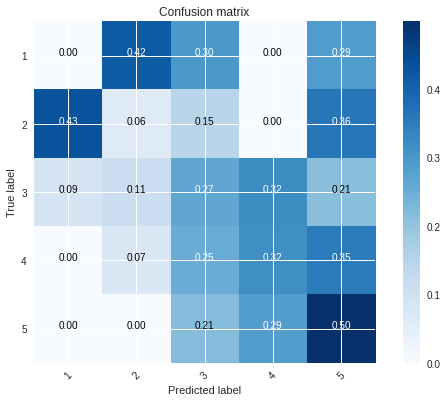

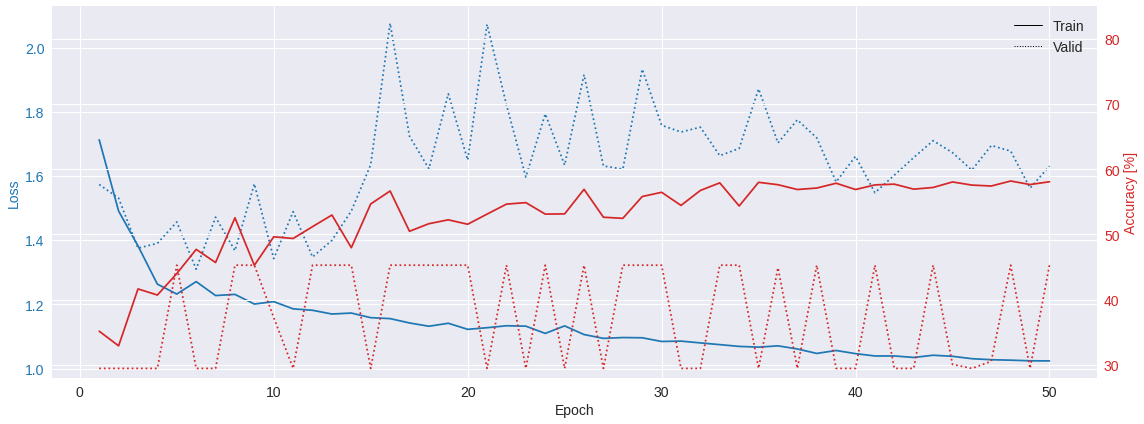

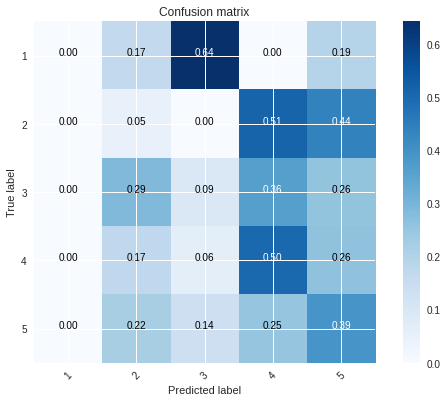

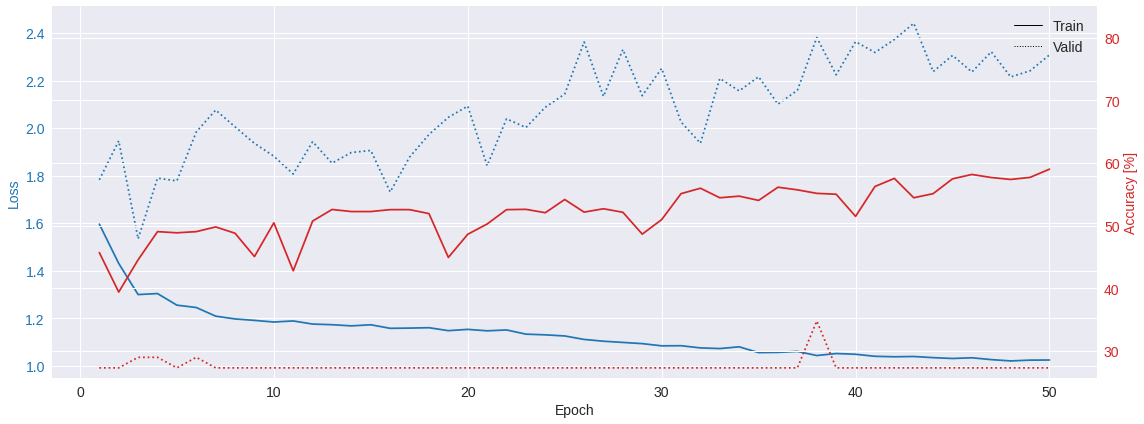

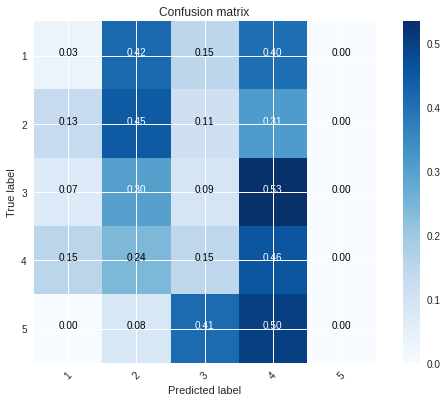

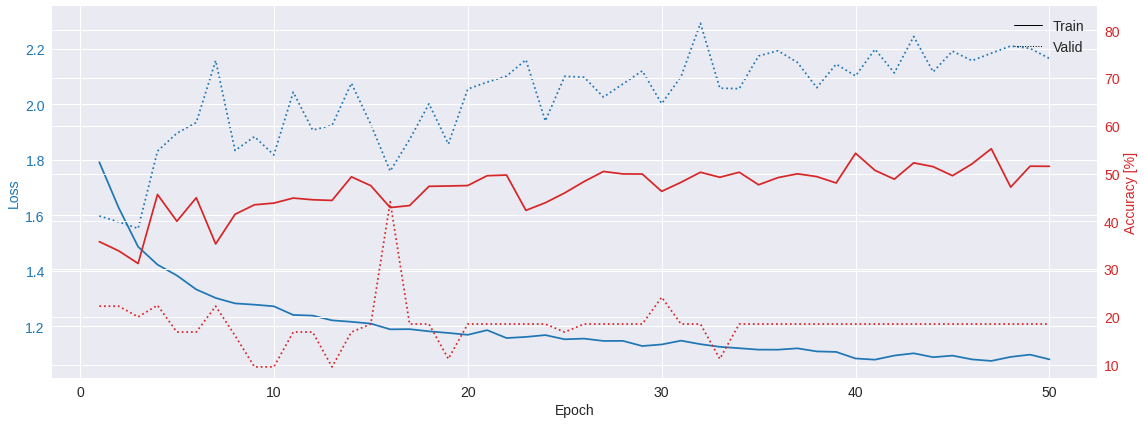

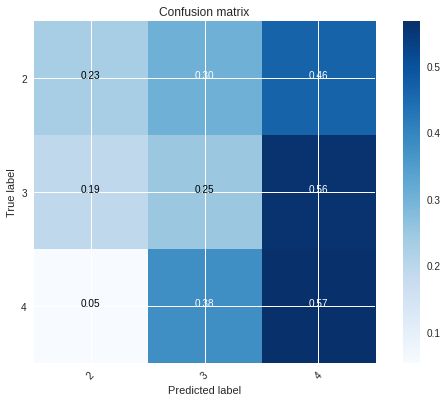

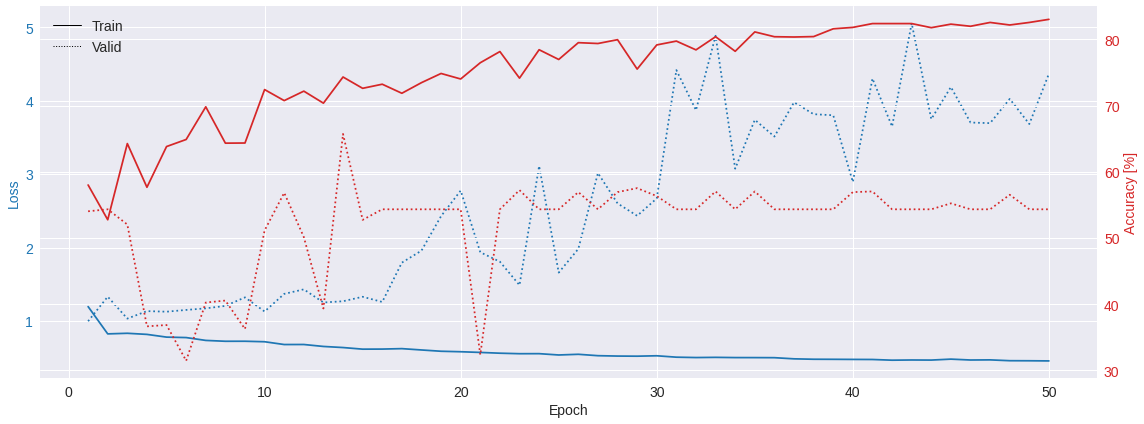

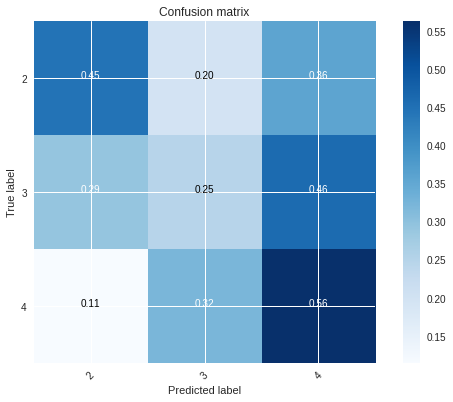

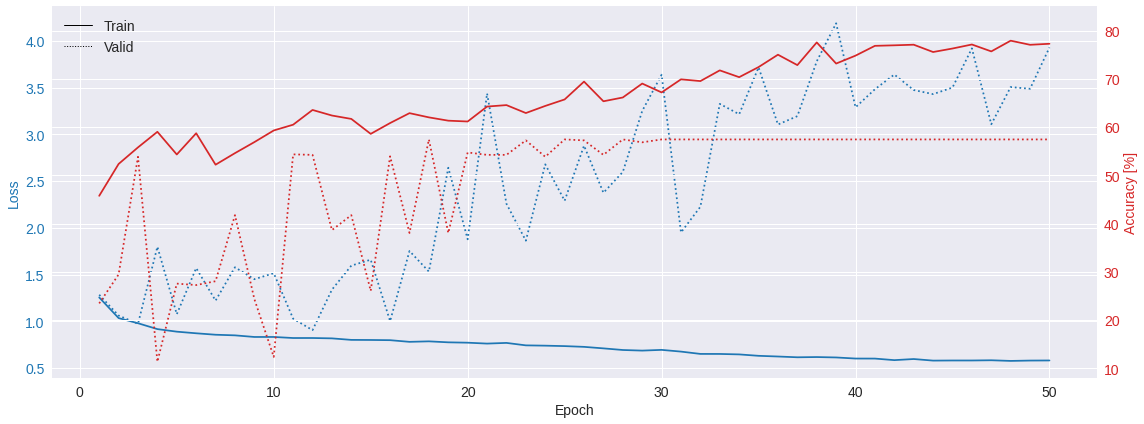

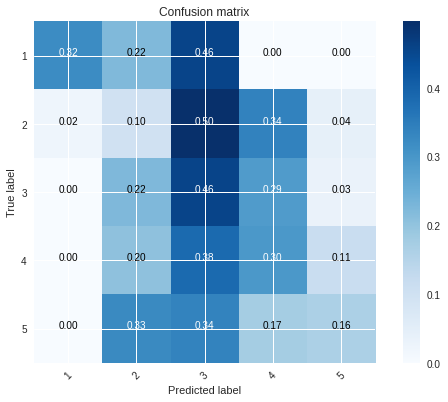

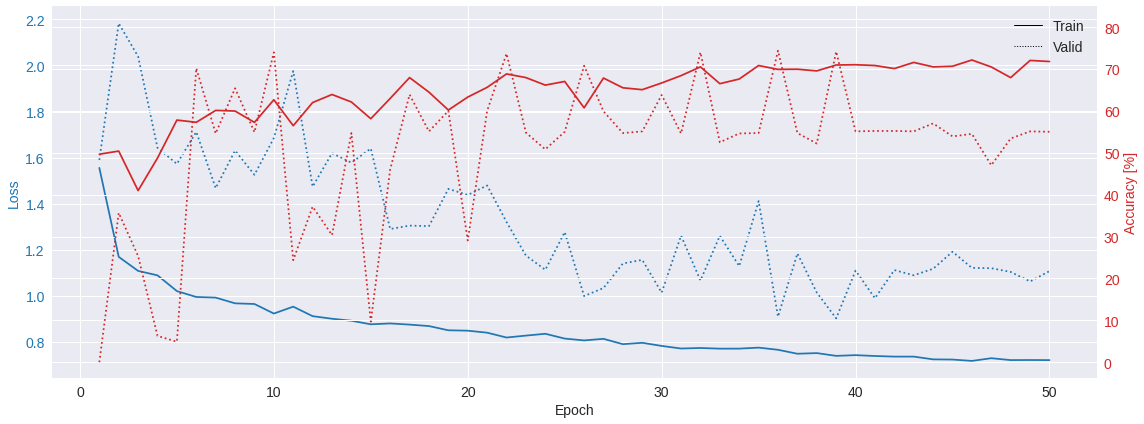

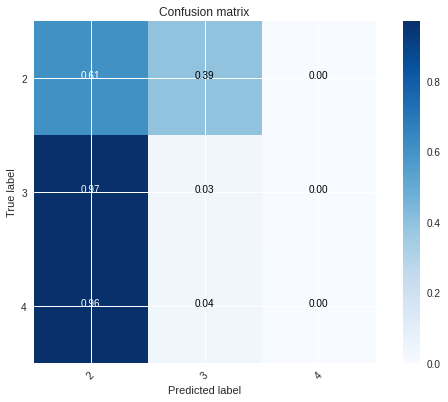

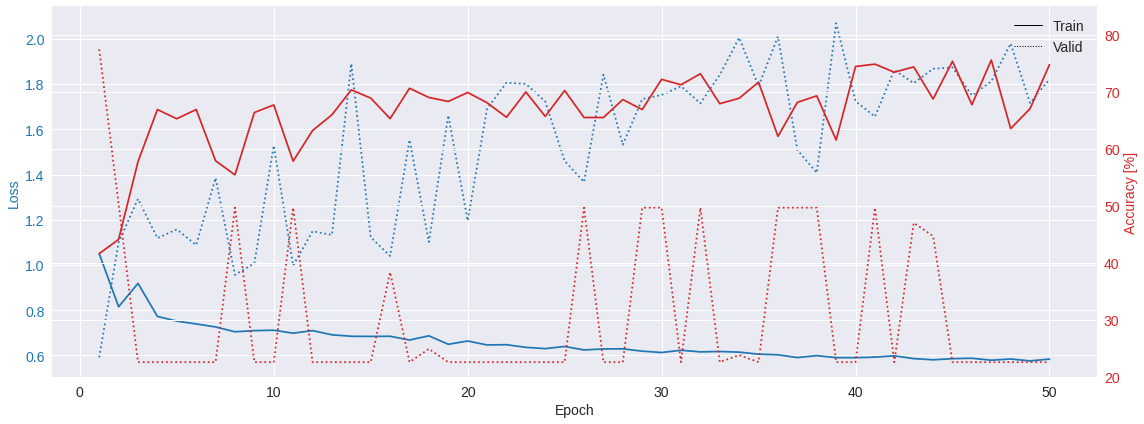

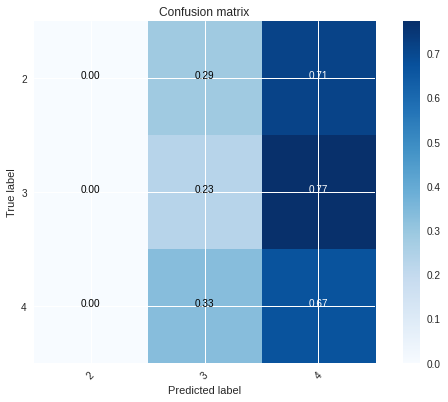

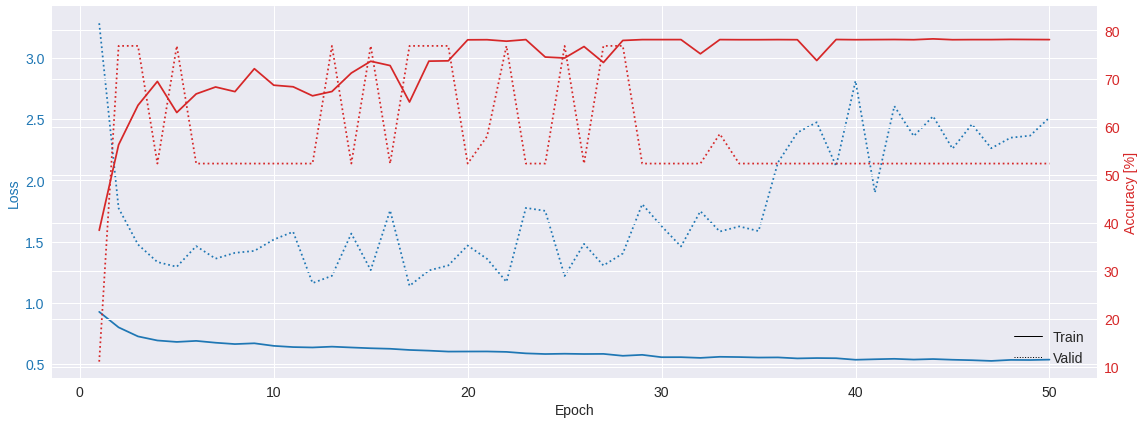

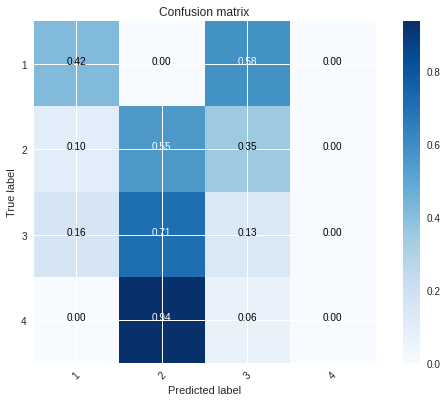

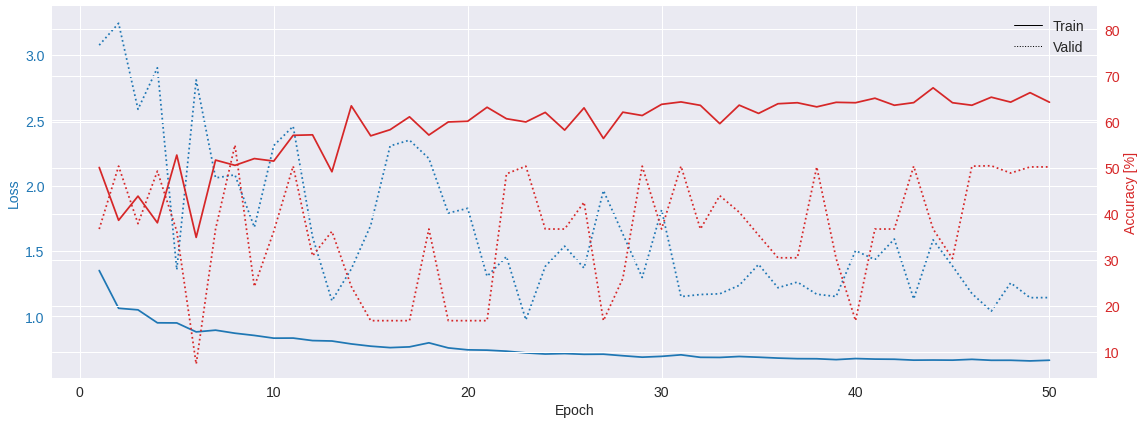

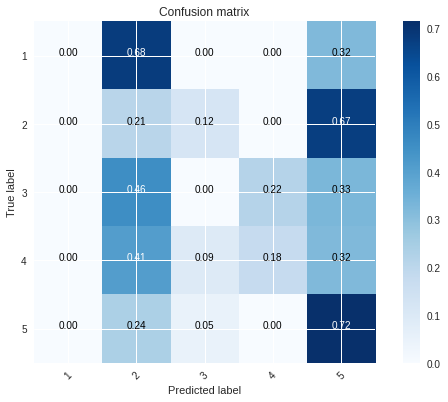

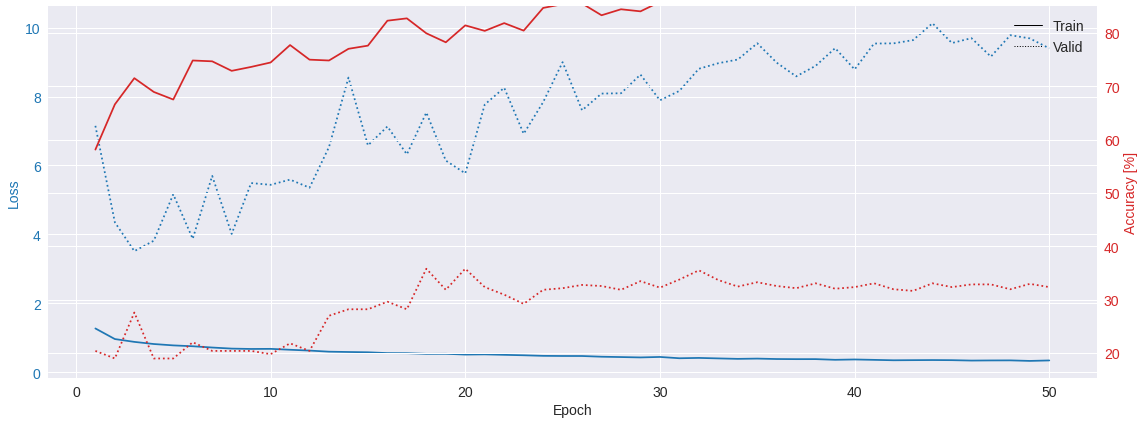

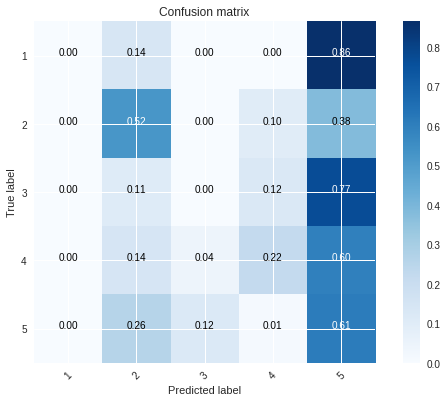

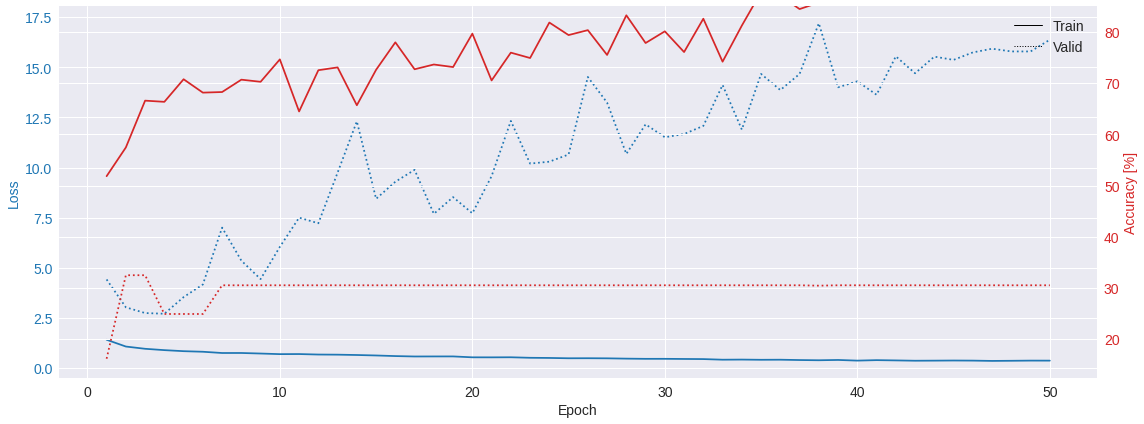

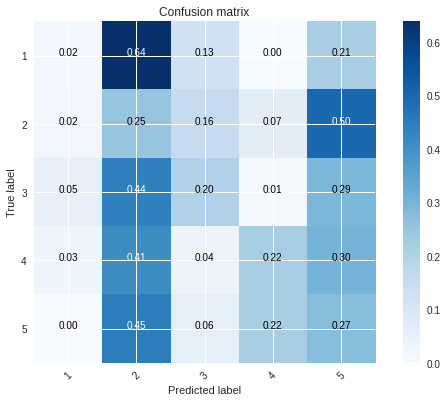

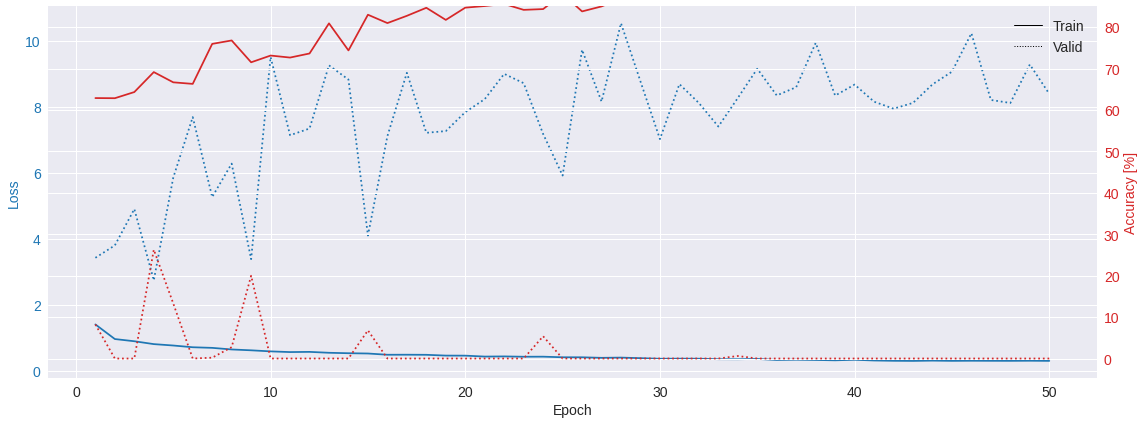

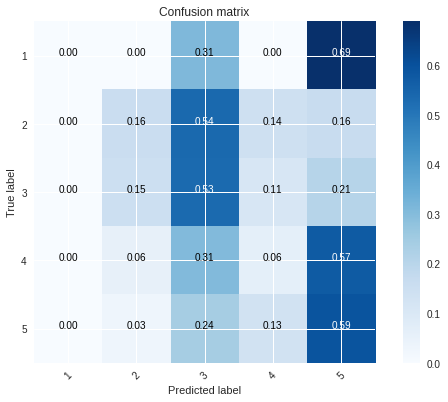

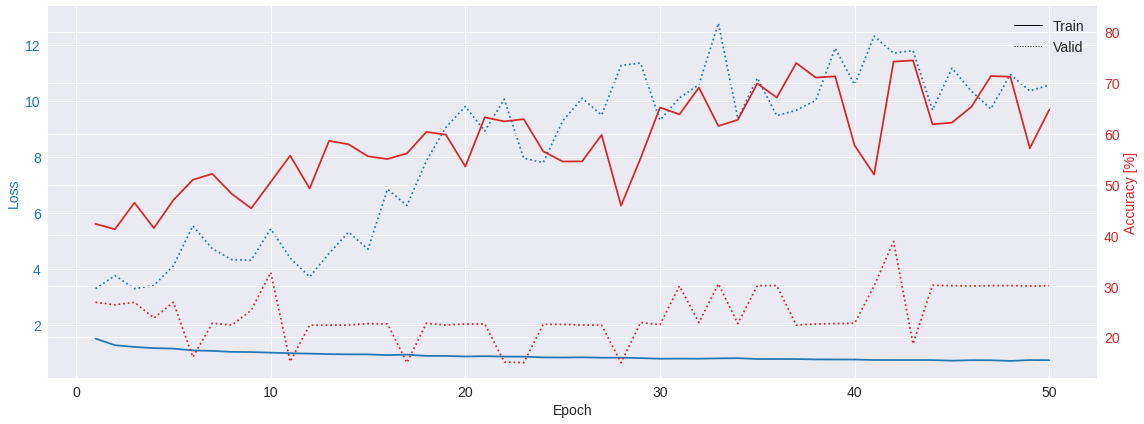

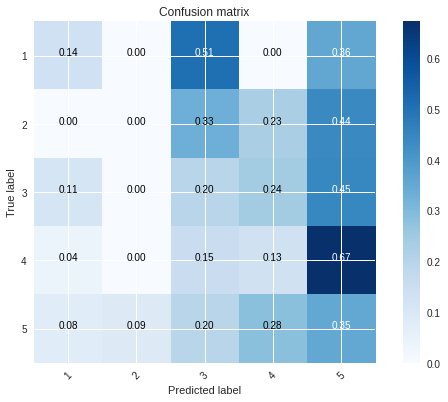

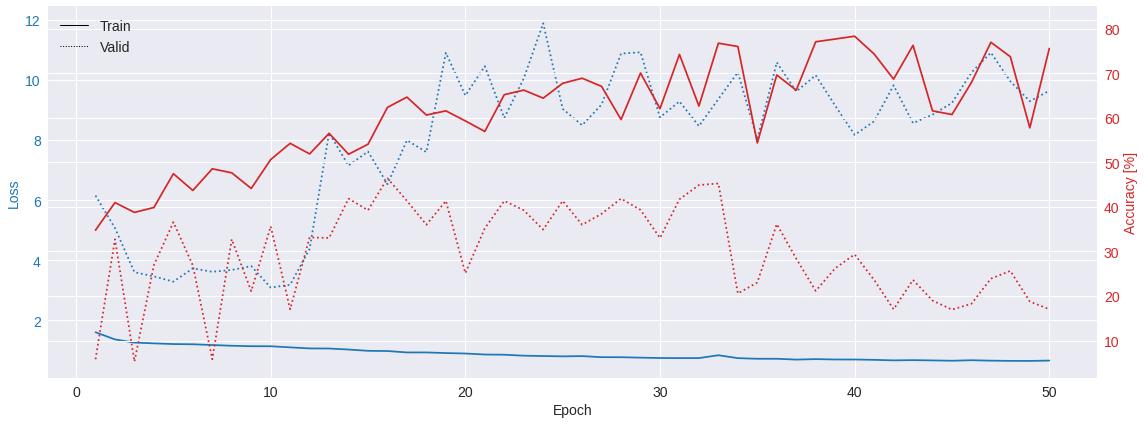

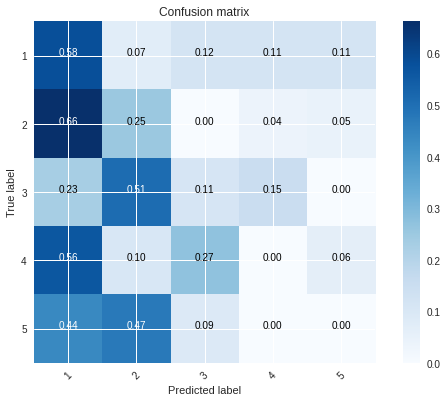

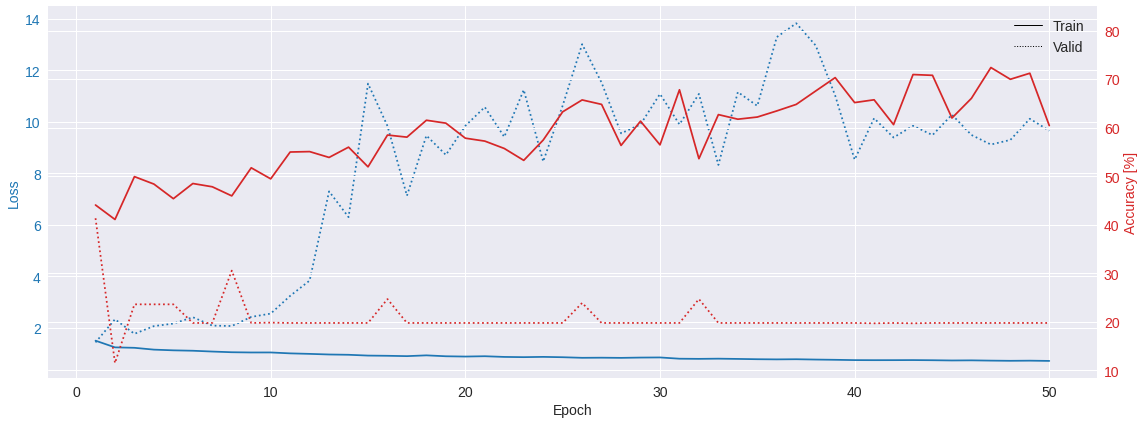

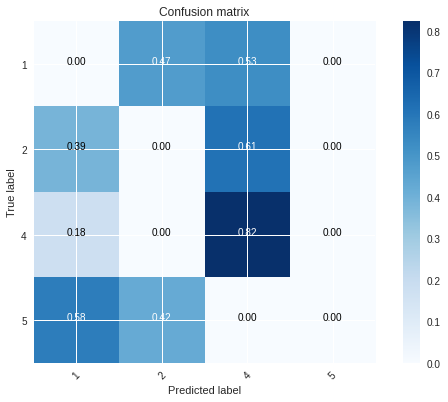

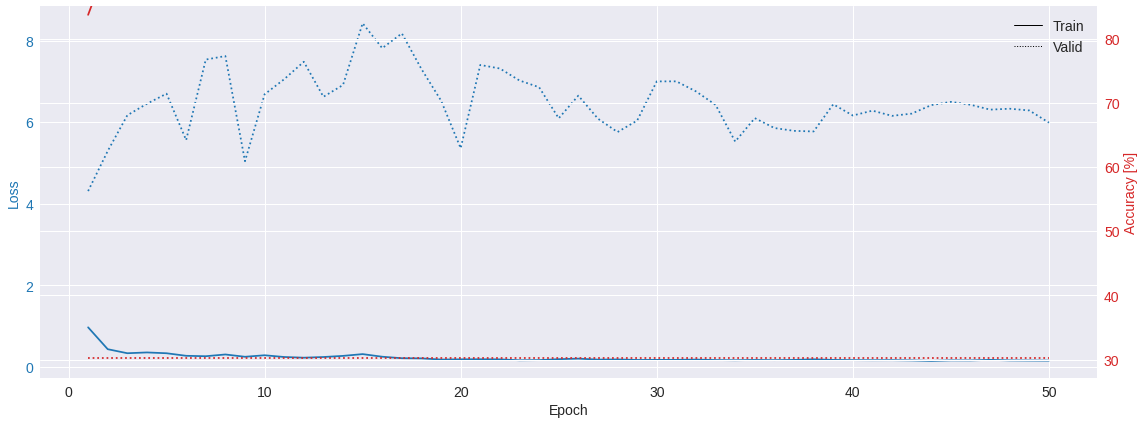

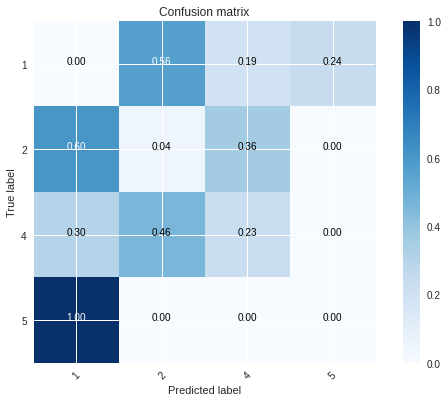

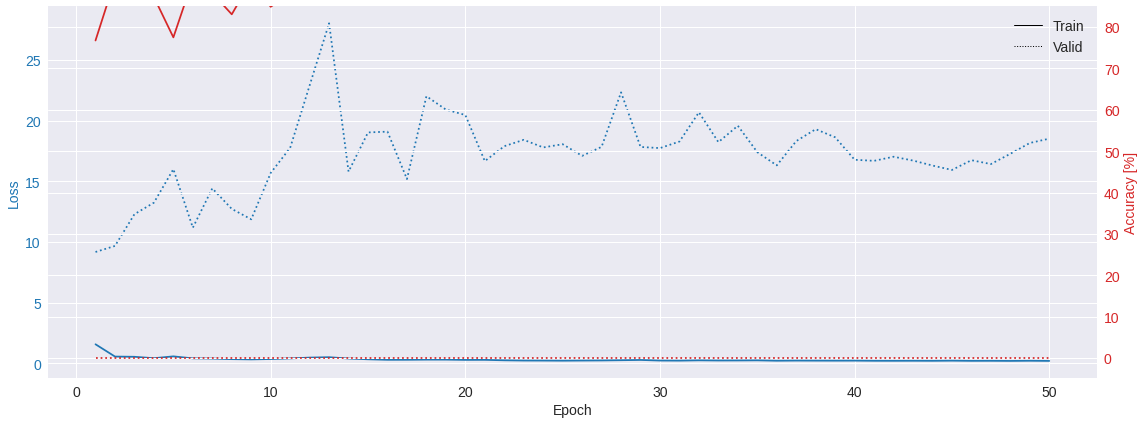

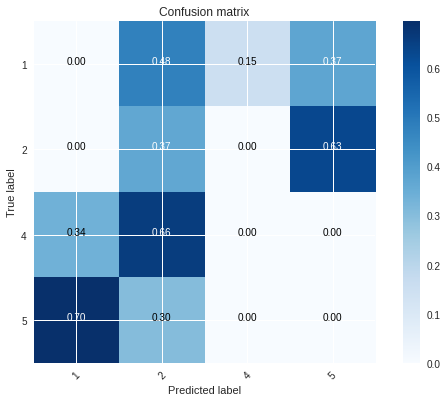

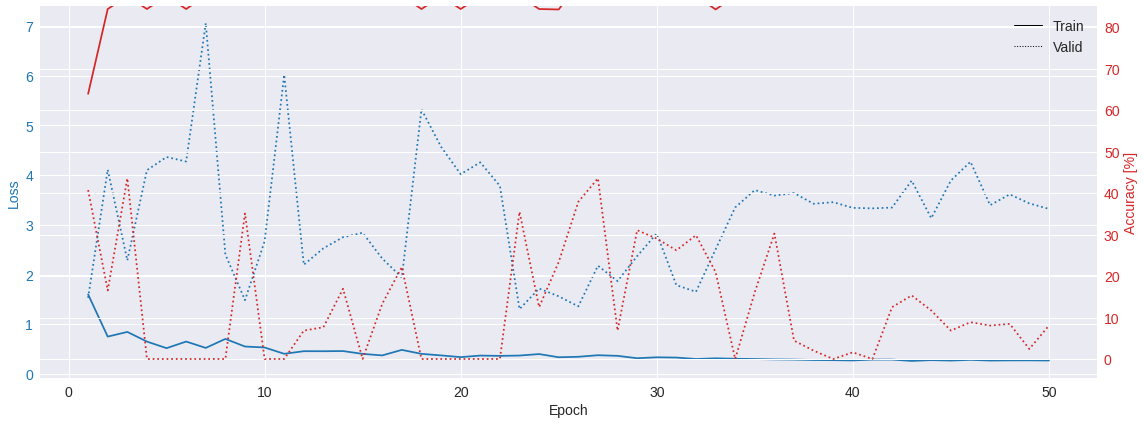

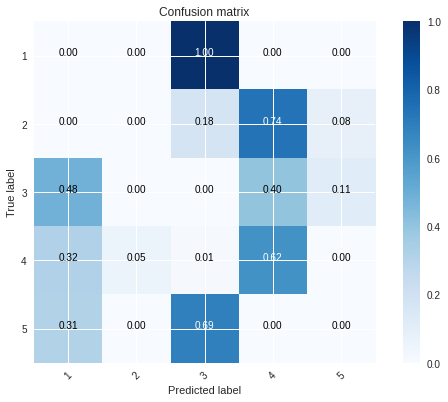

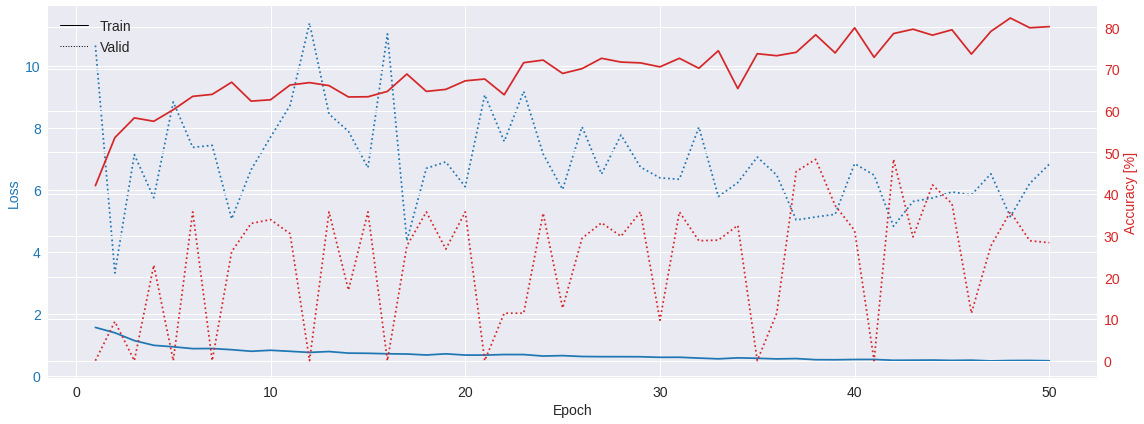

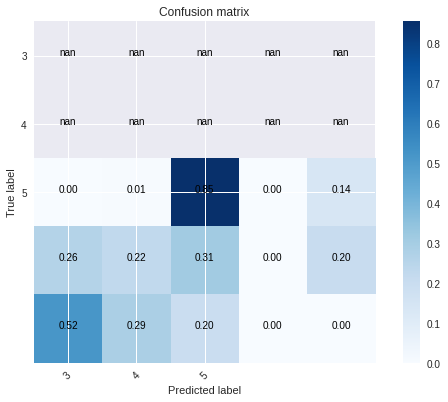

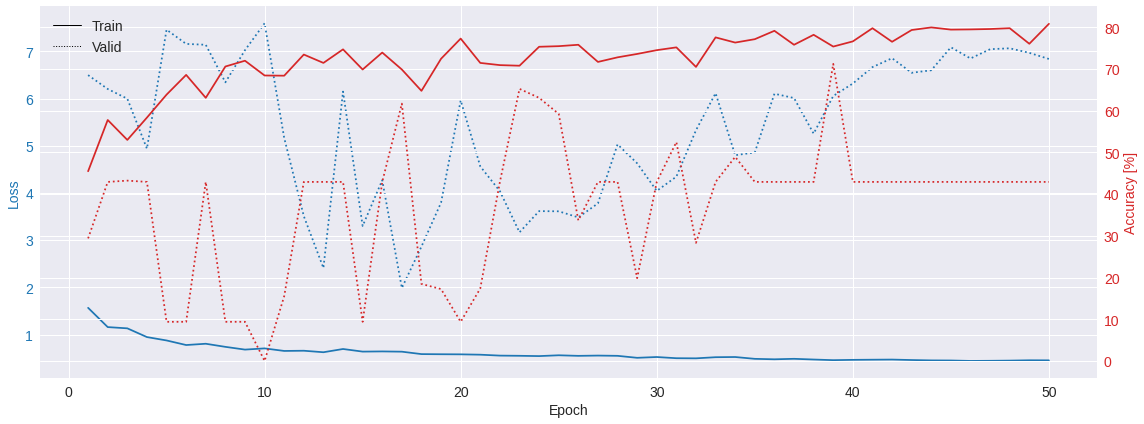

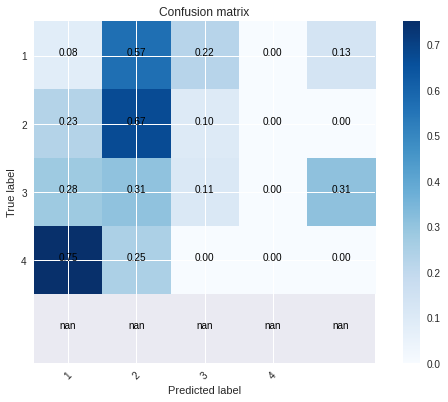

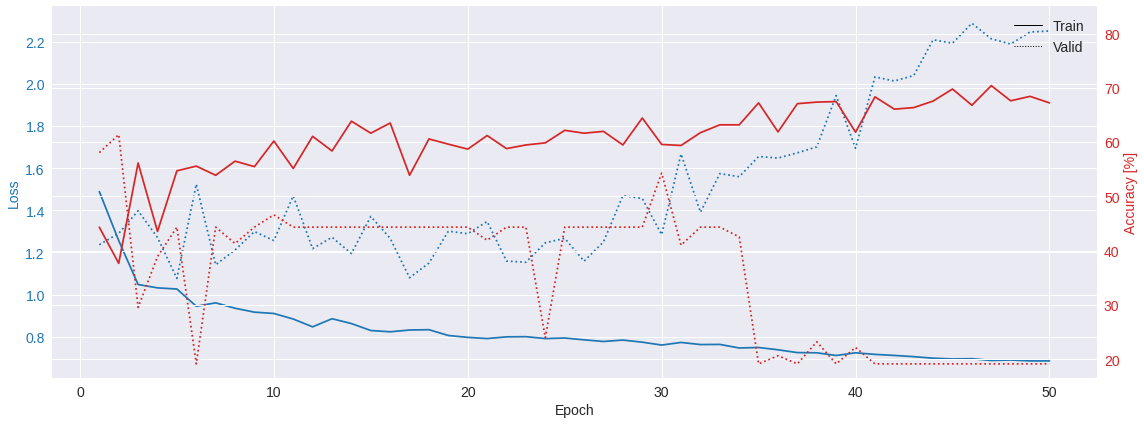

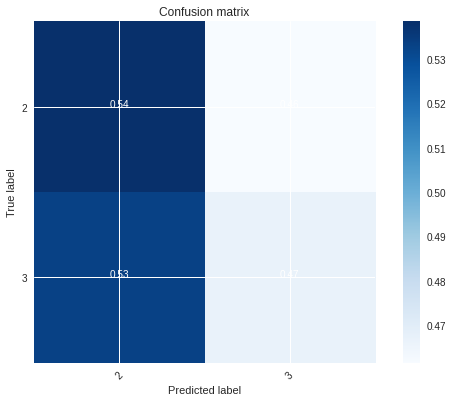

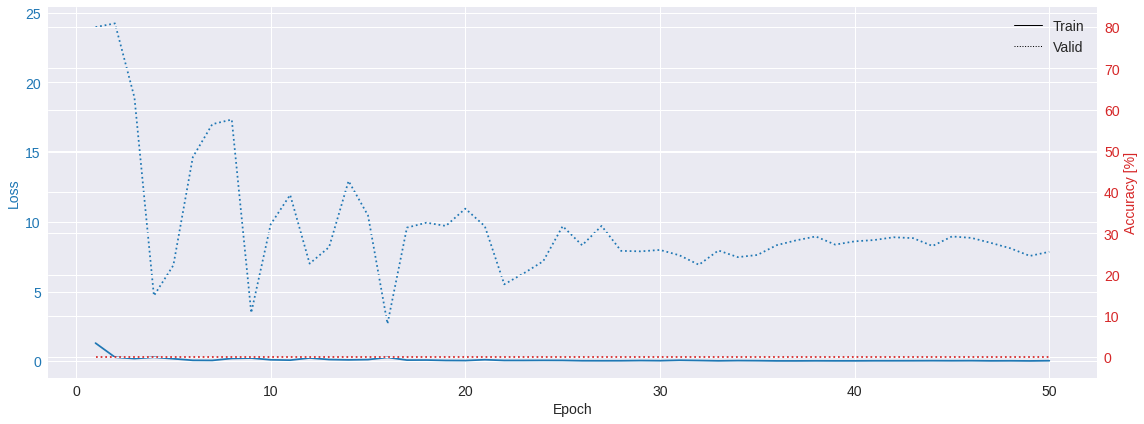

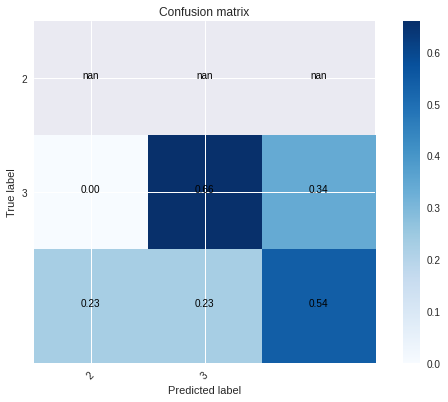

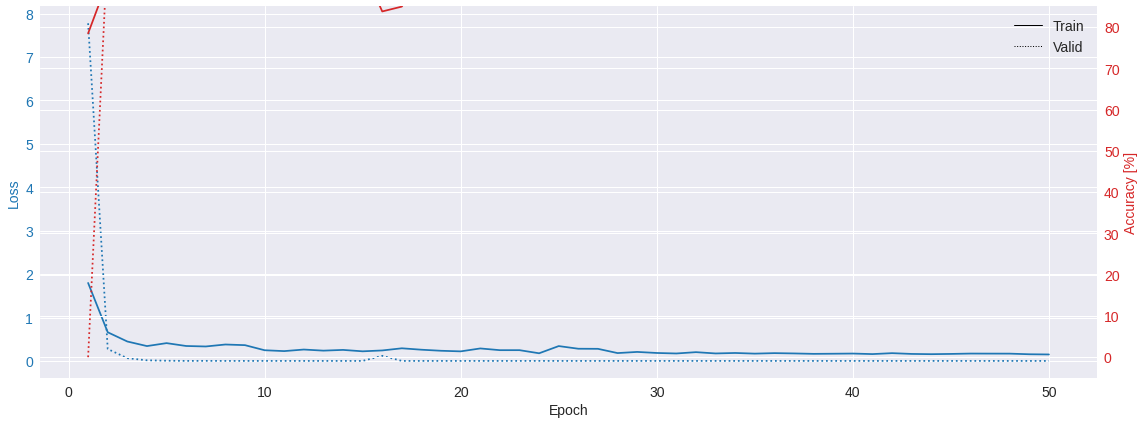

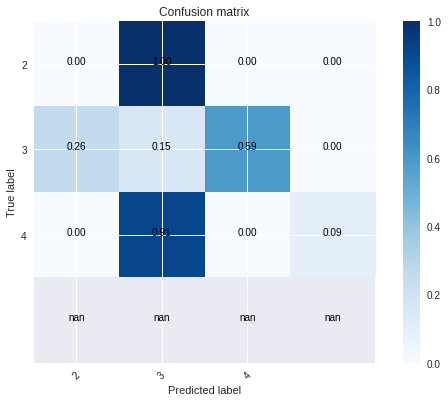

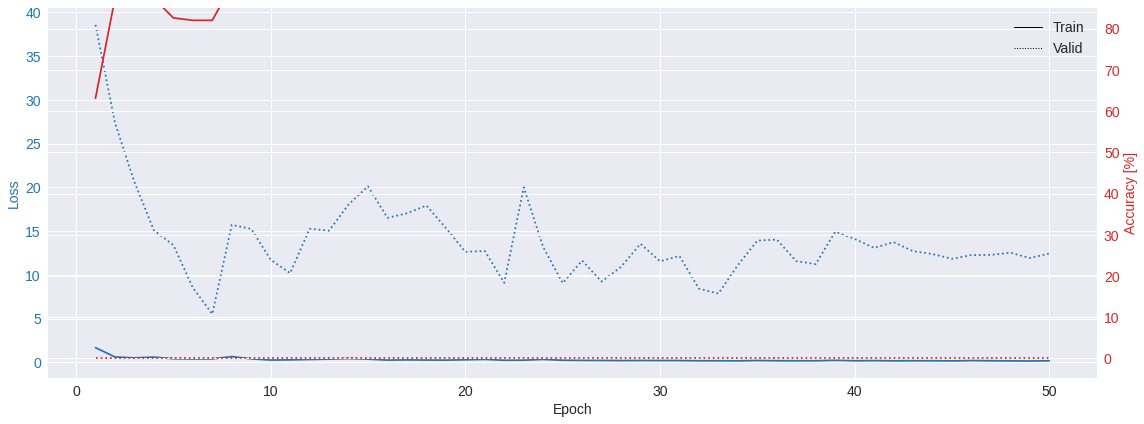

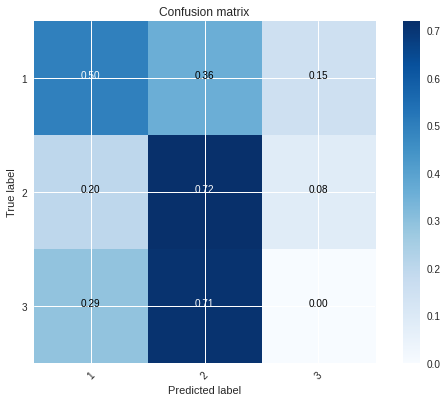

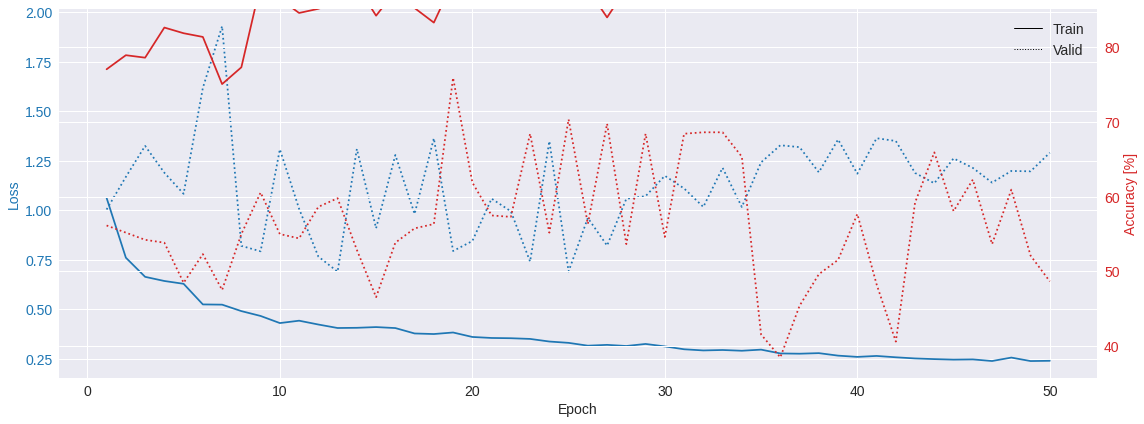

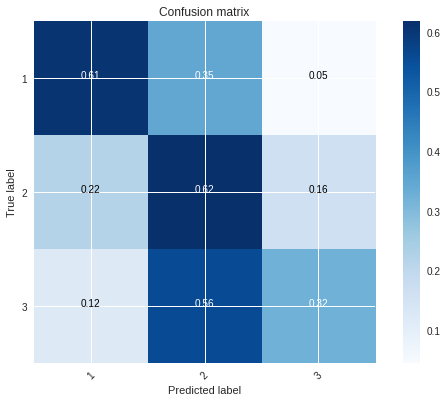

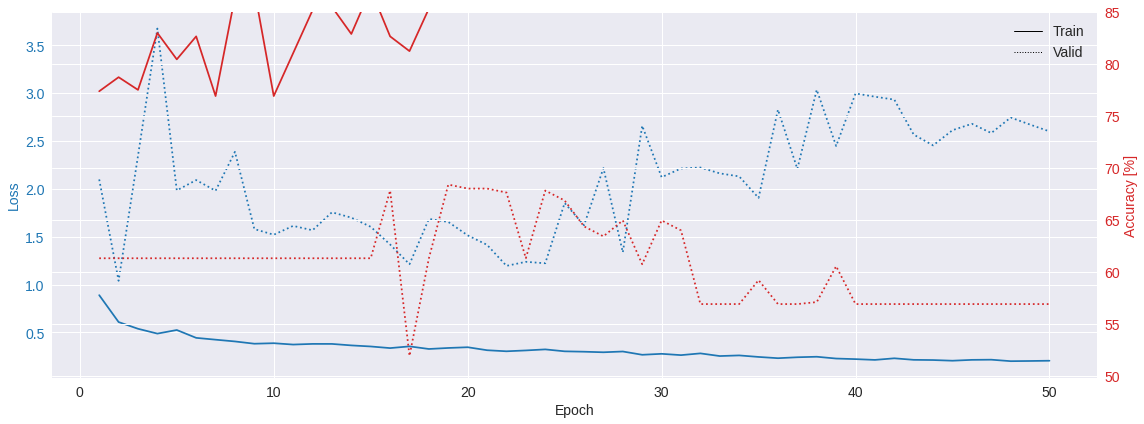

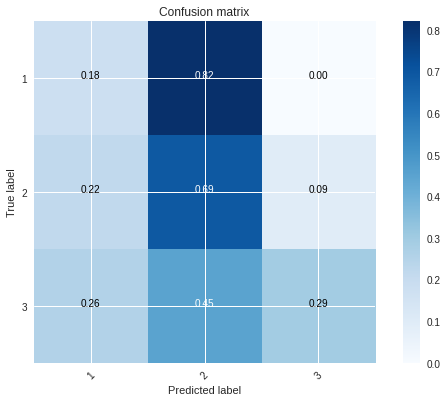

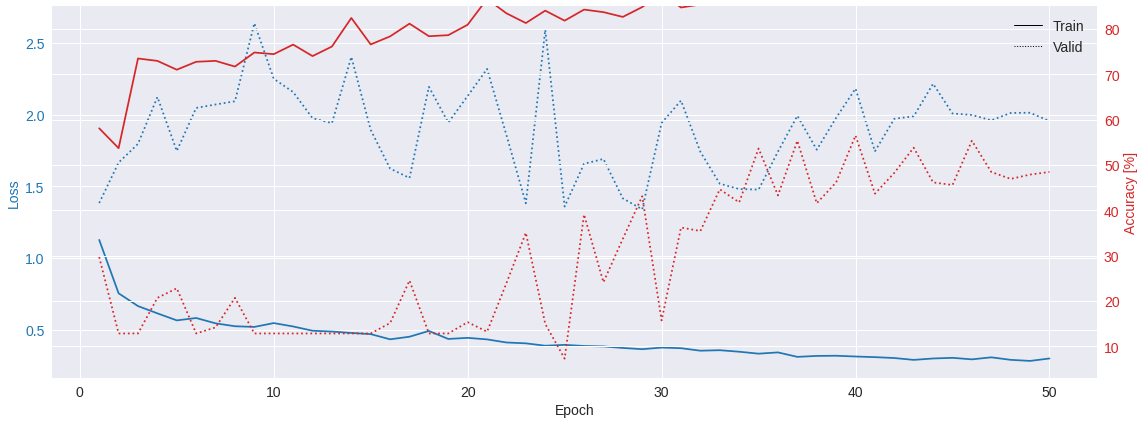

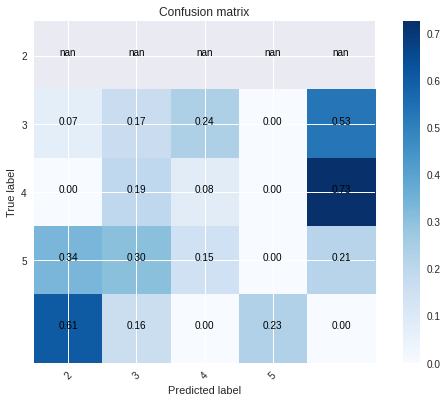

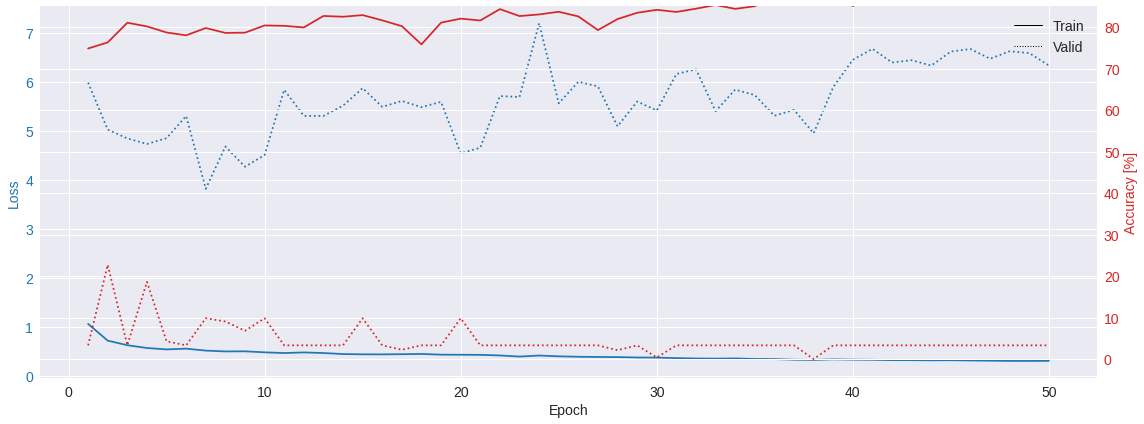

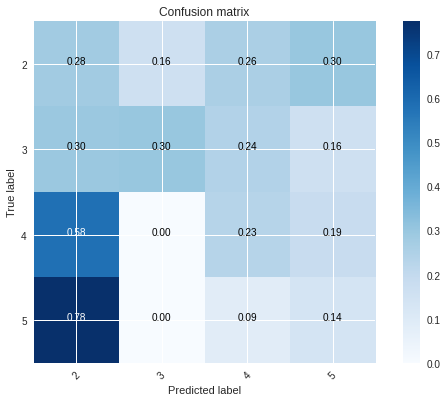

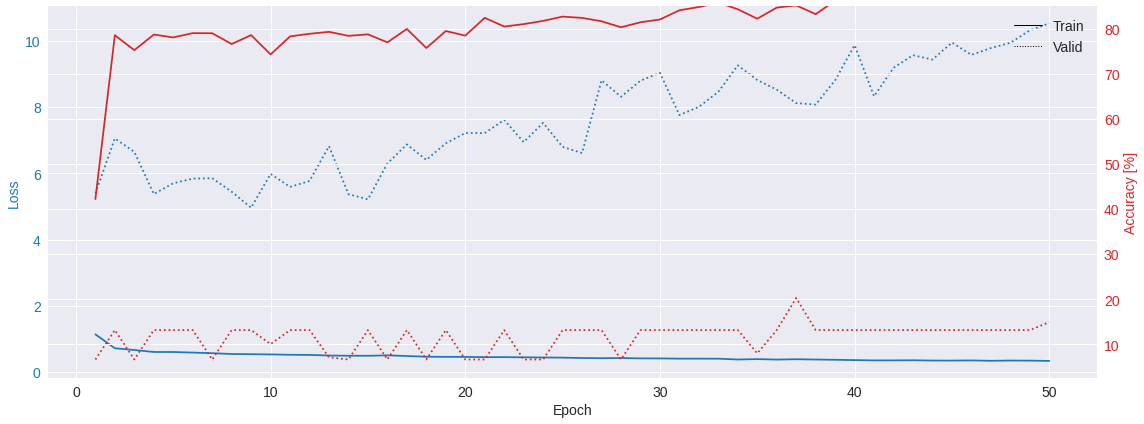

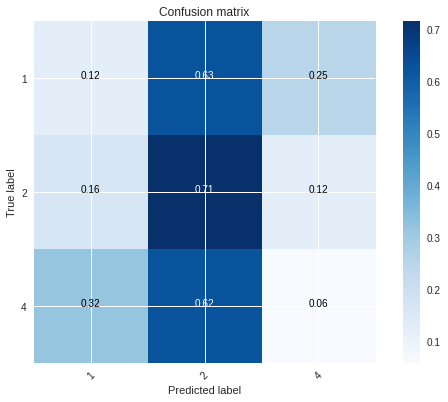

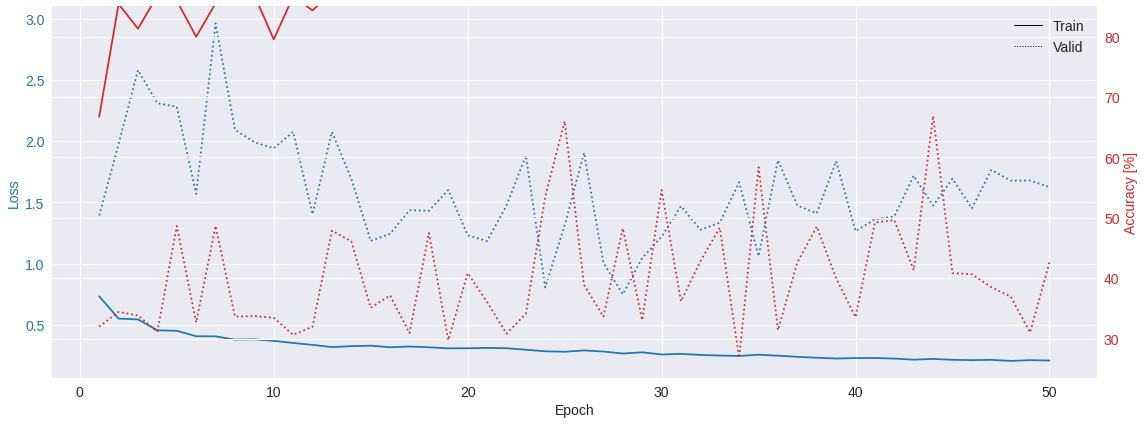

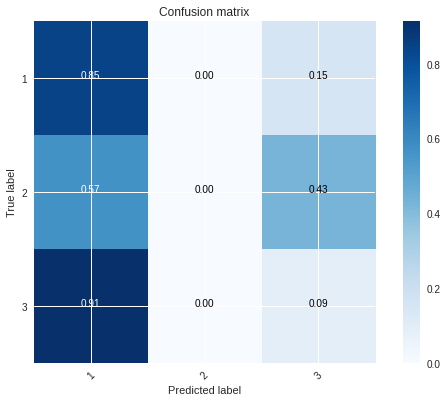

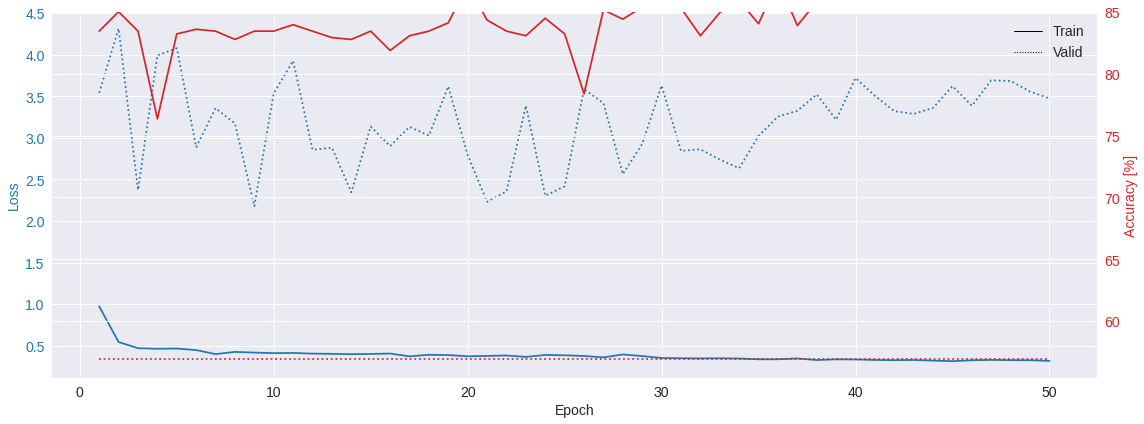

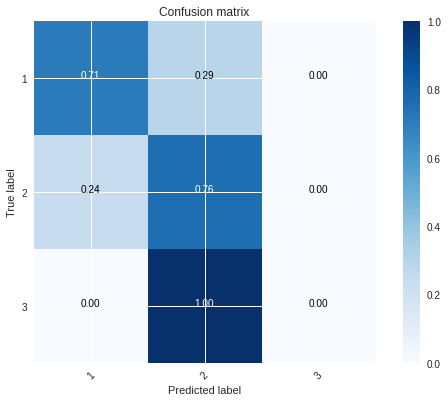

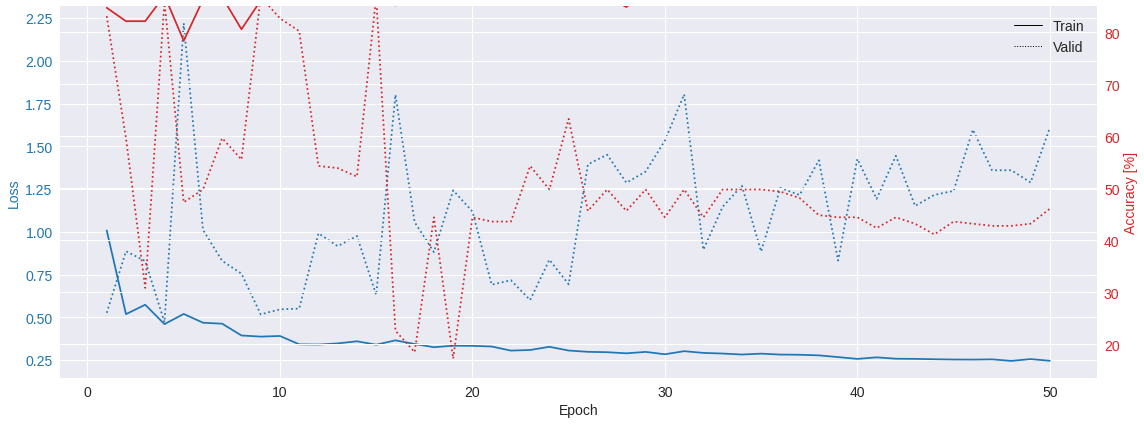

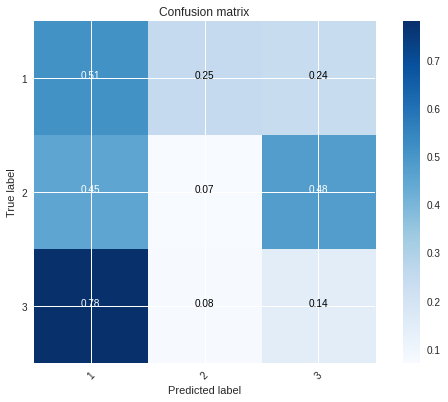

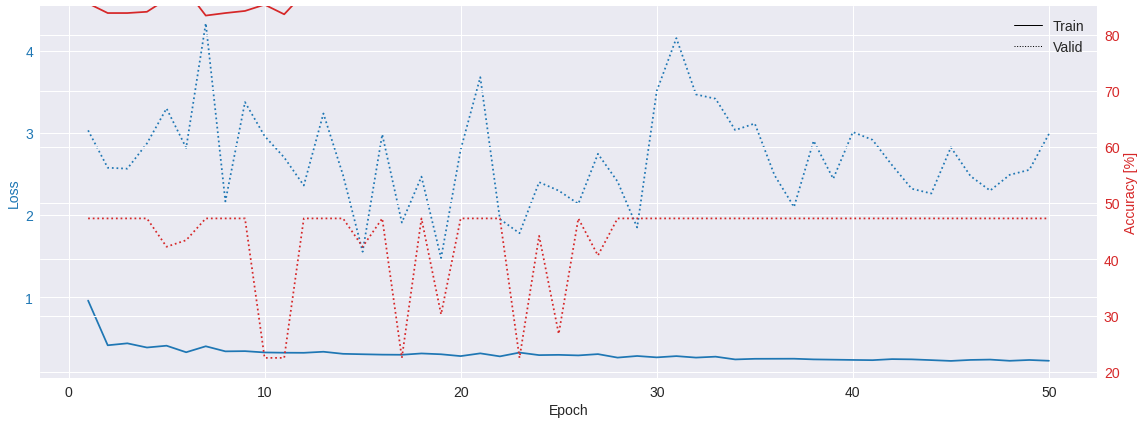

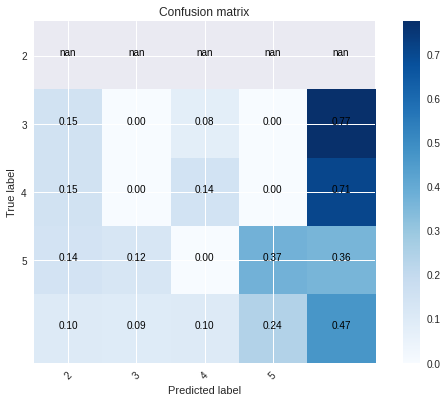

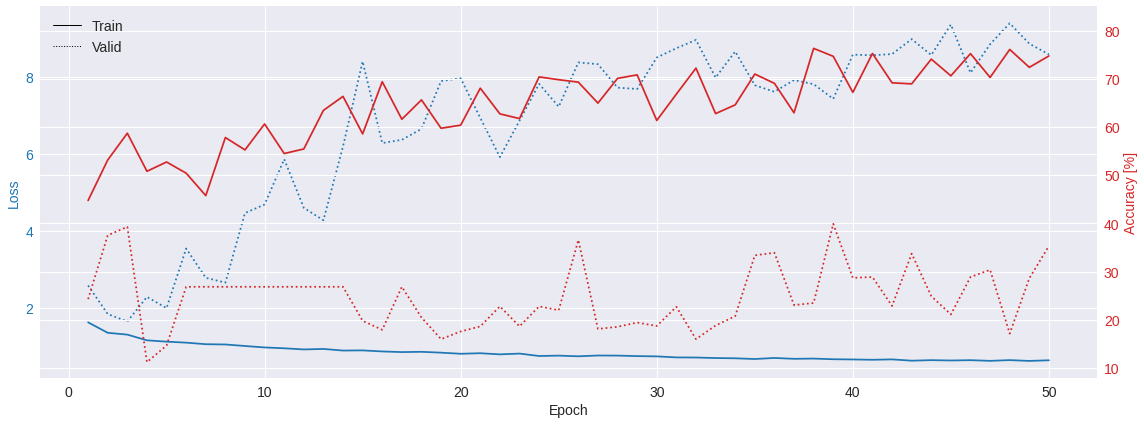

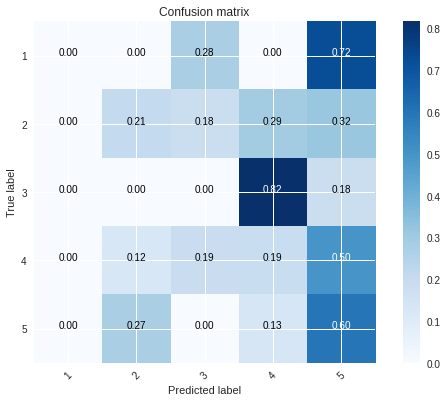

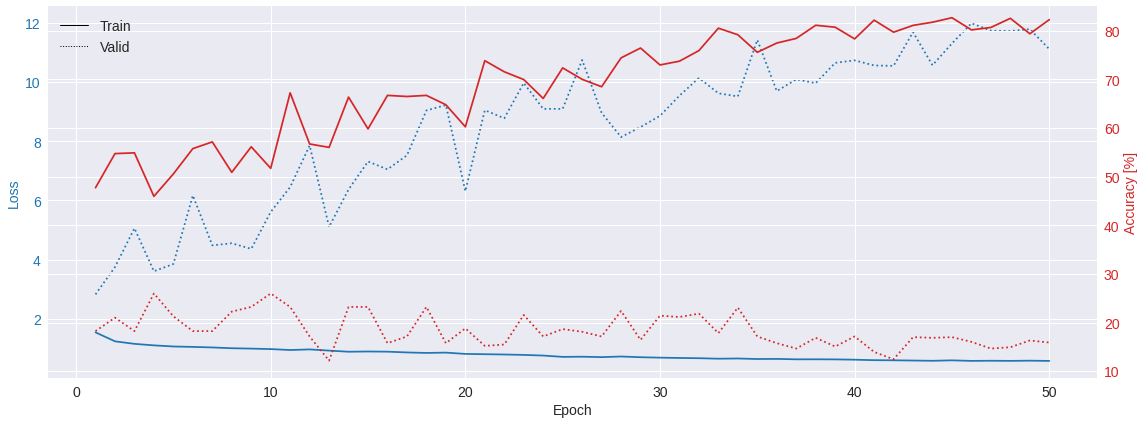

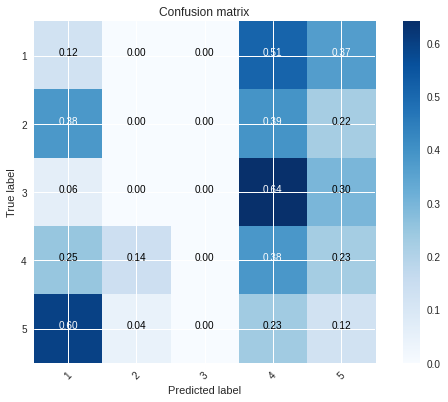

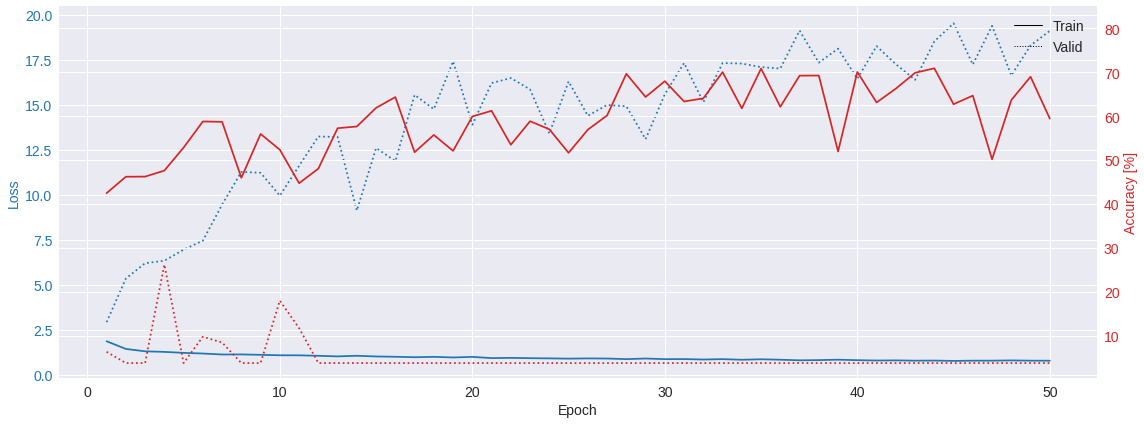

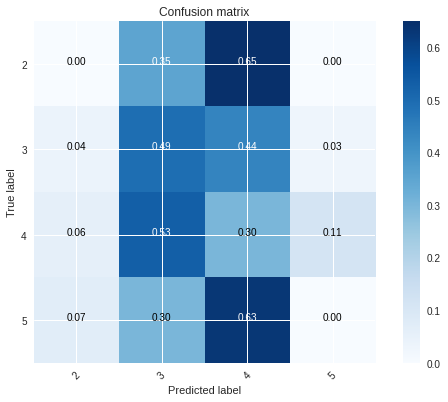

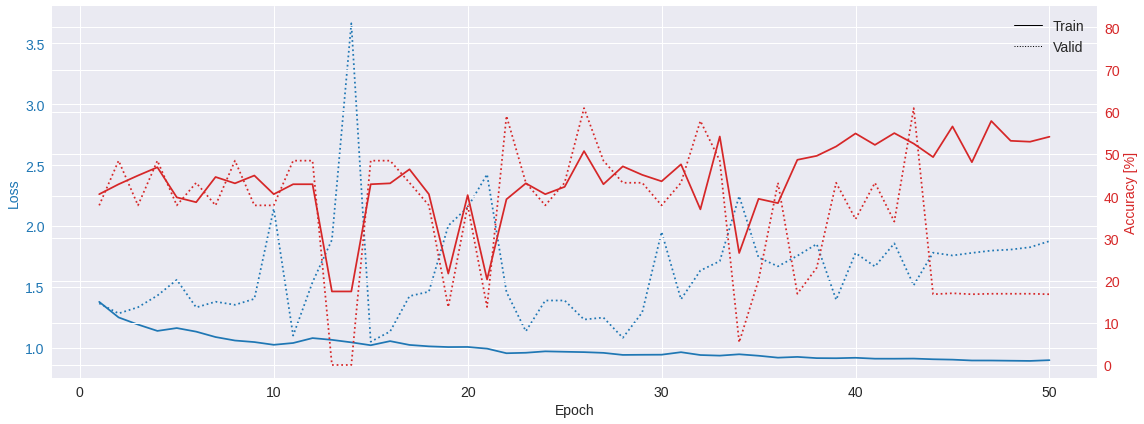

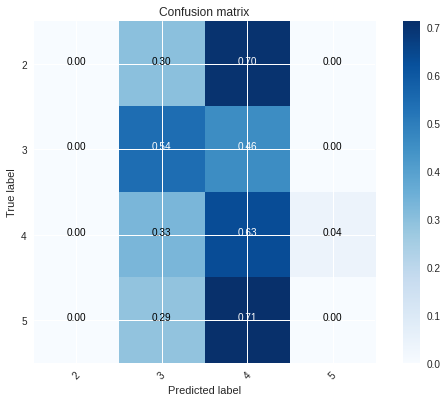

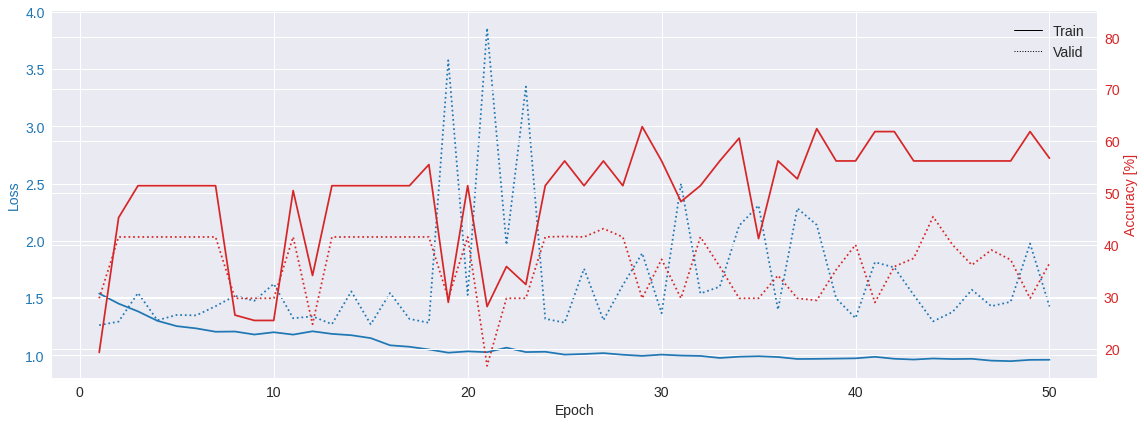

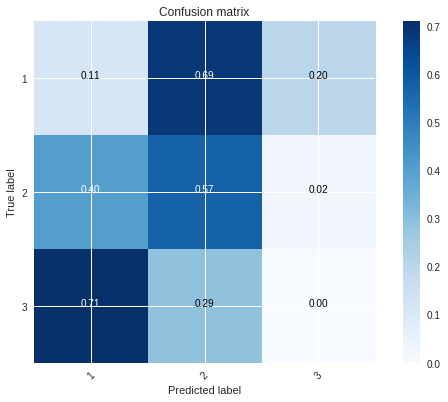

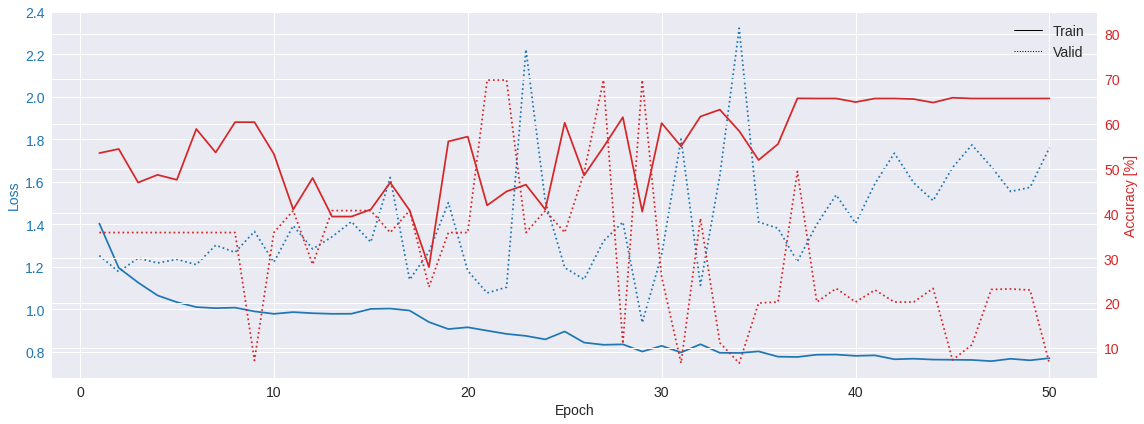

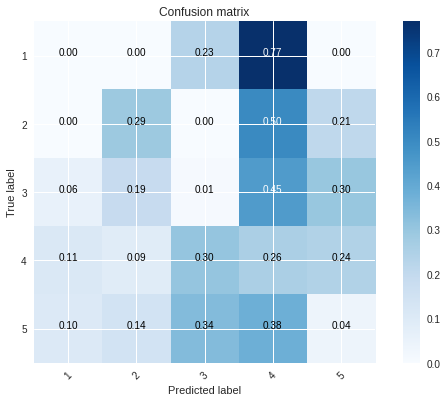

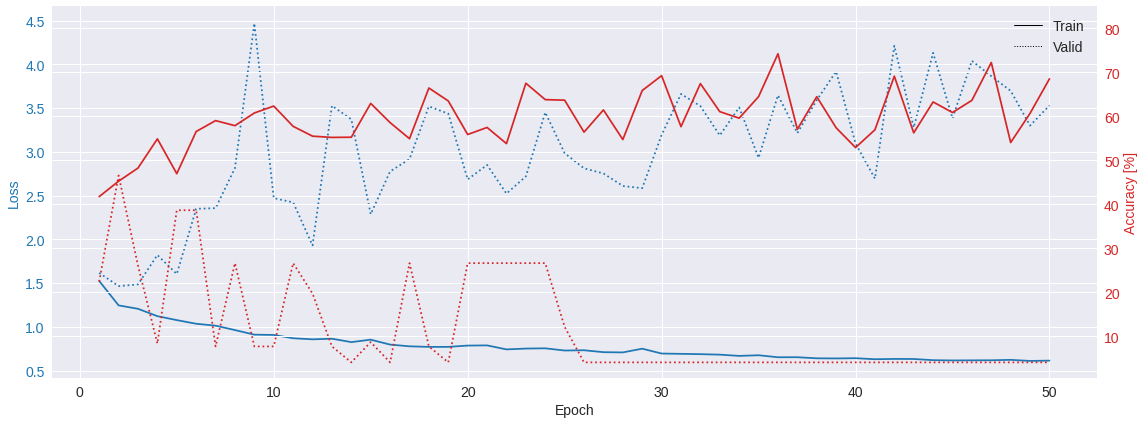

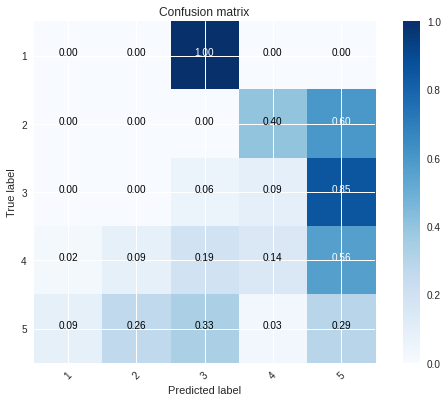

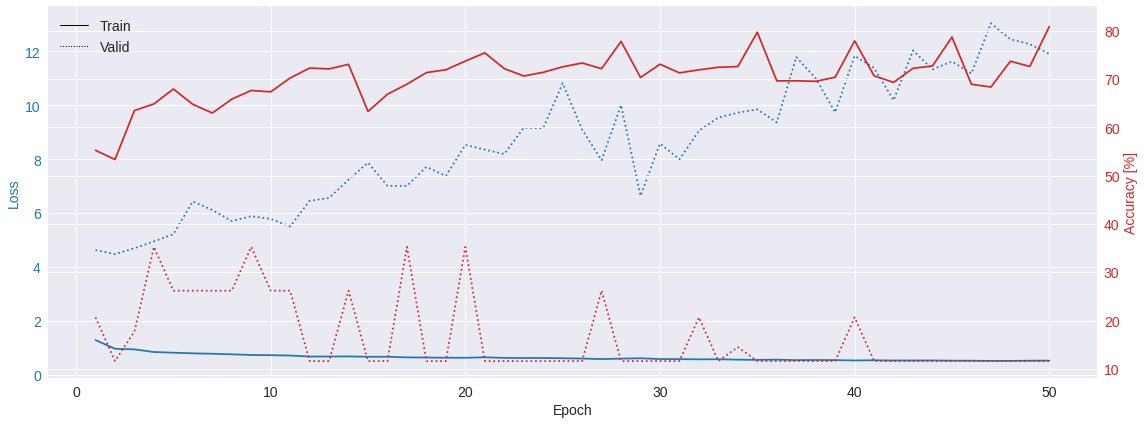

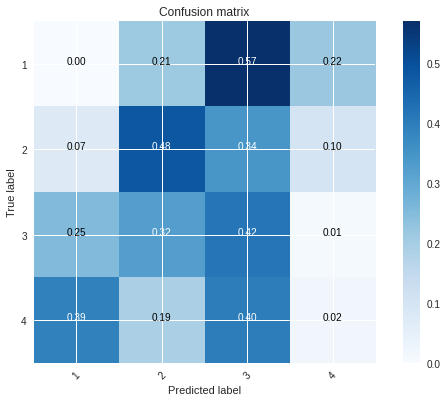

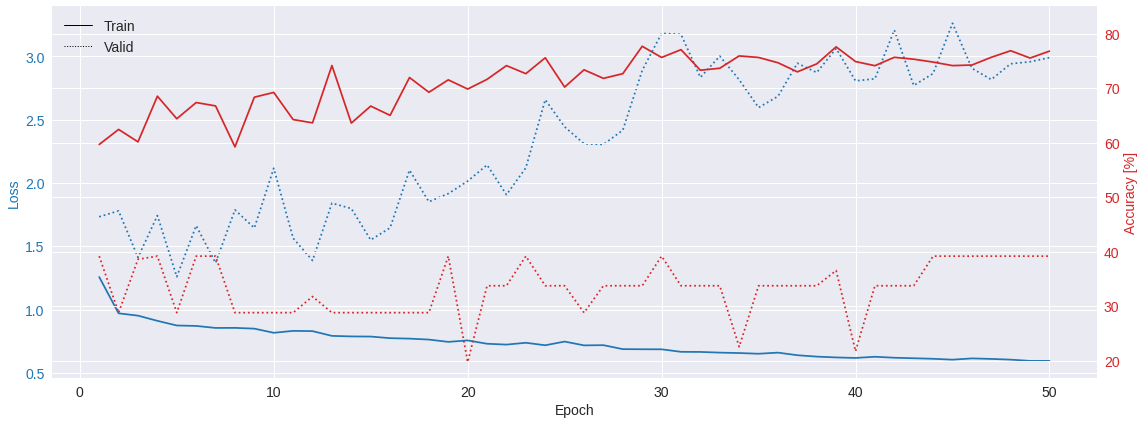

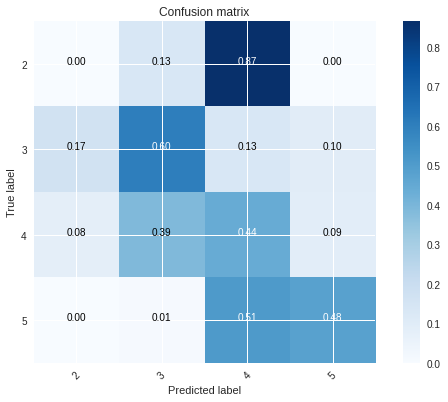

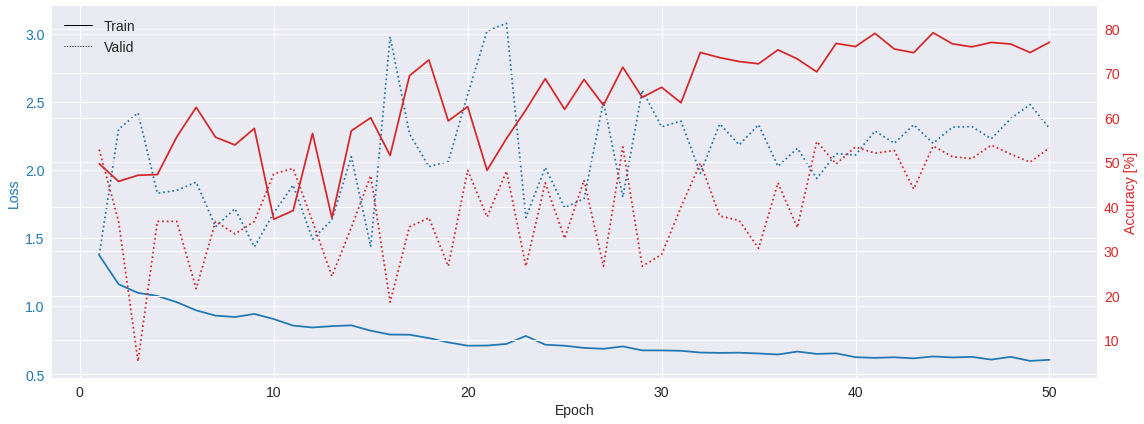

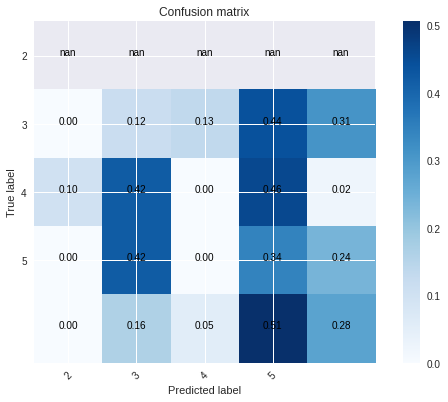

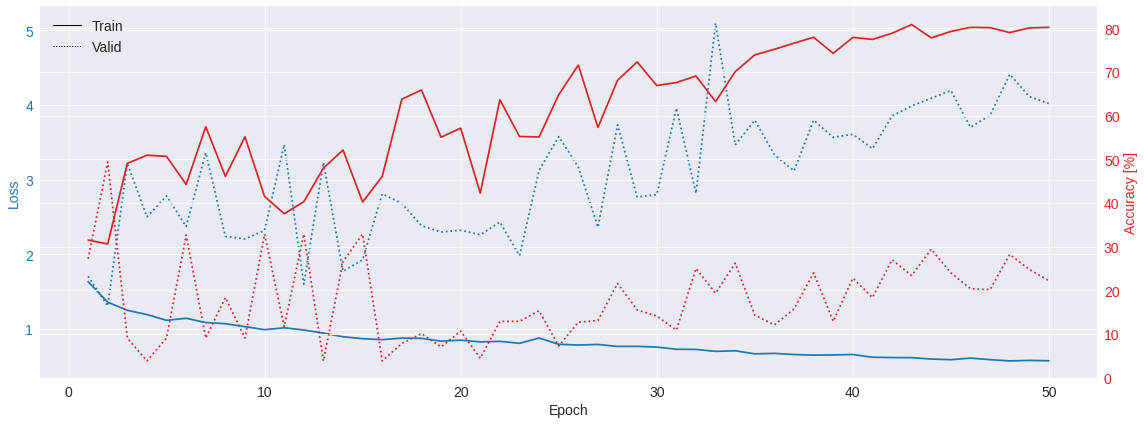

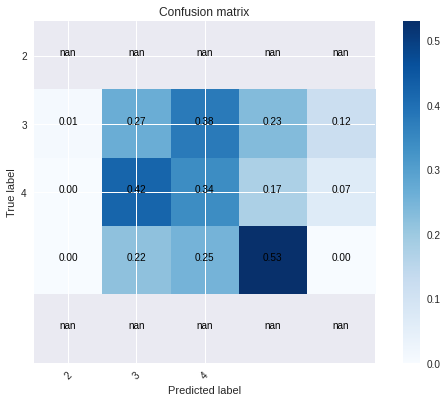

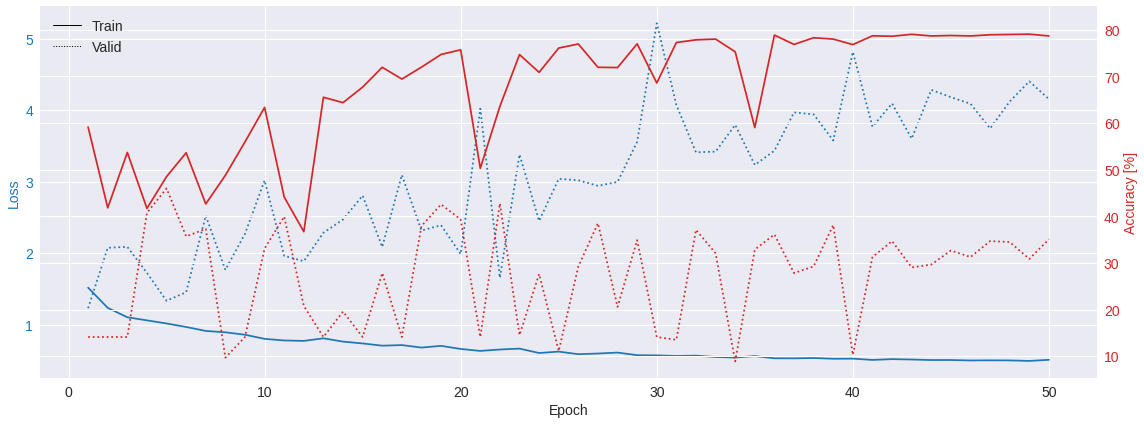

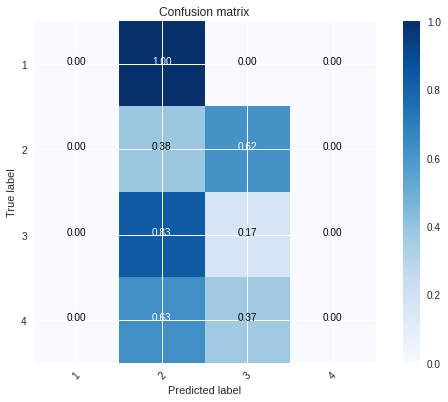

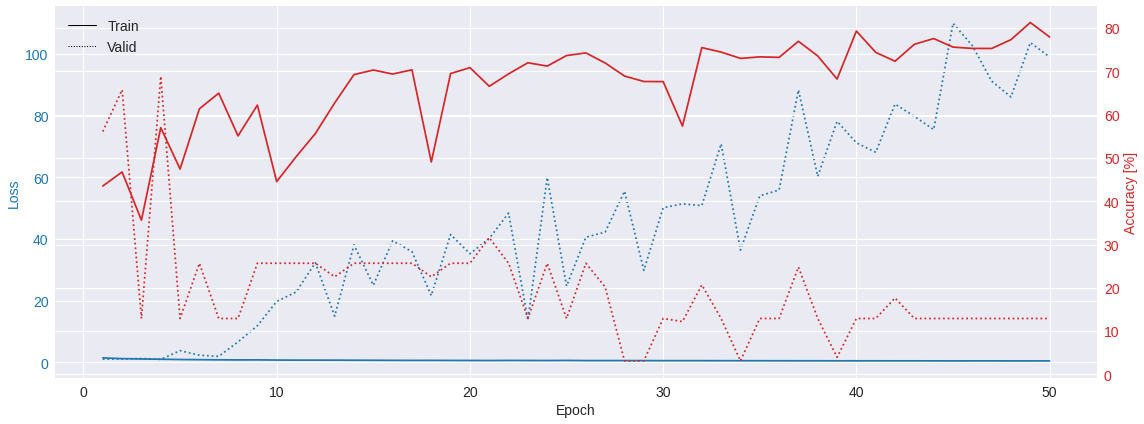

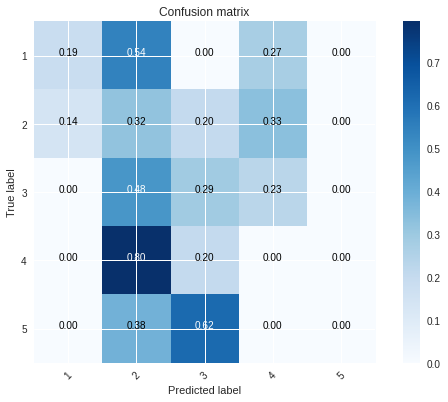

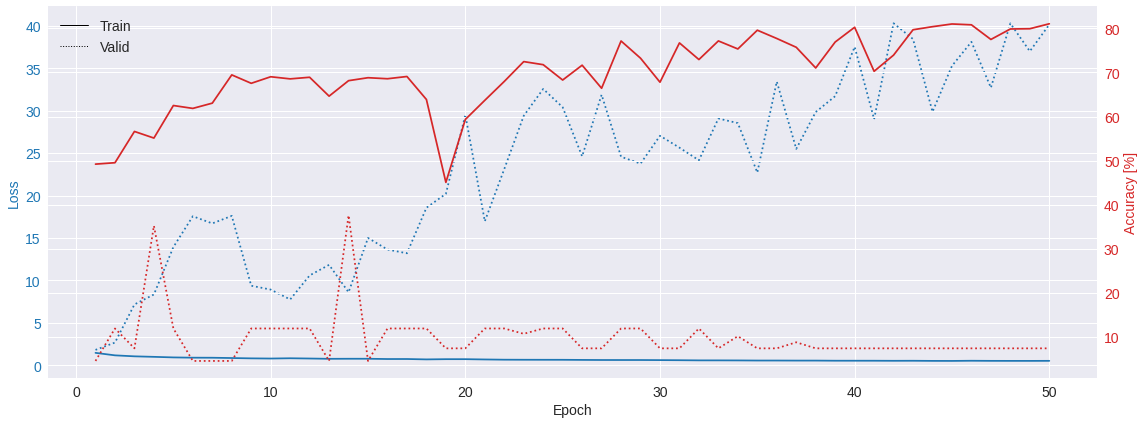

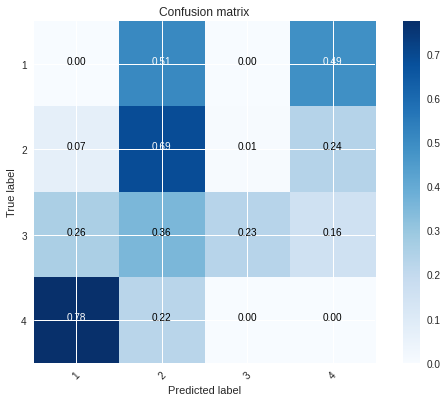

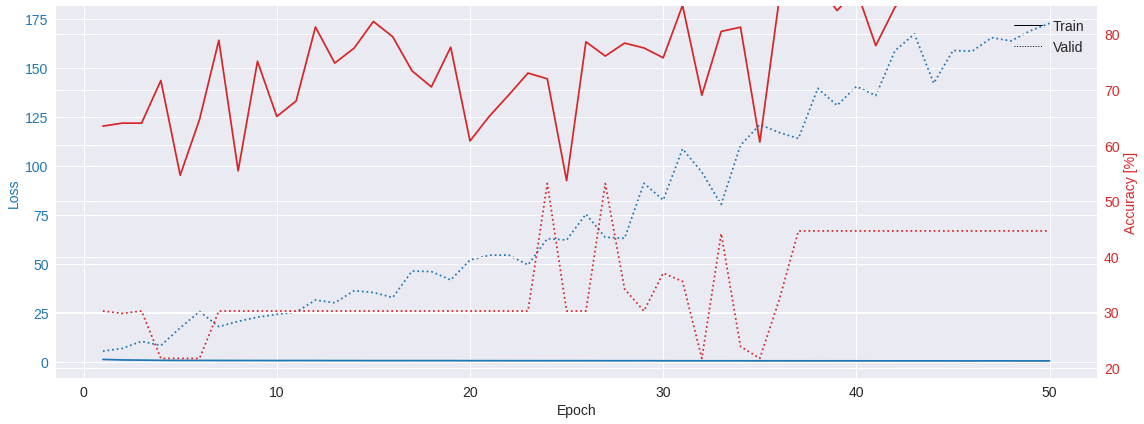

In [13]:
def run_per_user():
    """
    Method for running the CNN per user
    """
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    window_size_samples = 30

    saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
    all_tests = load_file(saved_file)
    users = all_tests.keys()
    n_epochs  = 50
    model_type = 'clf'
    for user in users:
        print("Working on user {0}".format(user))
        torch.backends.cudnn.benchmark = True

        for label in labels:
            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).transpose(0,2,1).astype(np.float32) for x in dt['inputs']])     
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # train and make predictions
            r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs)
            print(r['Accuracy'])

             # get results
            Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
            results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                                  r['F1 Score Macro'], r['F1 Score Micro']))

            # plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            saved_file = "results/CNN/confusion/k fold/User_{0}_{1}.png".format(user,label)
            plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

            #plot loss curve
            plot_loss_curve(clf)
            plt.savefig("results/CNN/loss curves/k fold/User_{0}_{1}.png".format(user,label))
            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/DeepCNN_Valid_performance_window_size_{0}_{1}_withclasses.csv".format(window_size_samples,label), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

In [ ]:
# # save model 
# saved_file = "models/attention_user_1_with_fi.pickle"
# with open(saved_file, 'wb') as handle:            
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
def run_cross_user():
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    window_size_samples = 30

    saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_30_window_annotated_EEG.pickle"
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    n_epochs  = 50
    model_type = 'clf'
    user ='all'
    torch.backends.cudnn.benchmark = True


    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()


        # convert the inputs  into #samples, channels, #timepoints format
        X = np.array([all_tests_agg[user]['inputs'].transpose(0,2,1).astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs, device, cuda)
        print(r['Accuracy'])

         # get results
        Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
        results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                              r['F1 Score Macro'], r['F1 Score Micro']))

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/confusion/k fold/cross user/Label_{0}.png".format(label)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

        #plot loss curve
        plot_loss_curve(clf)
        plt.savefig("results/CNN/loss curves/k fold/cross user/Label_{0}.png".format(label))
        print("Finished analysis on label {0}".format(label))
    print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/DeepCNN_Valid_performance_window_size_{0}_cross_user.csv".format(window_size_samples), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

    model_path =  "/cs/home/ybk1/Dissertation/data/models/cross_user_30_window.pickle"
    save_file(model_path,clf)